# SAN - Praktische Arbeit (Marvel Universe Social Network)

## Netzwerkanalyse

In [275]:
import os
import sys
import random
import itertools
import pandas as pd
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite, centrality, community
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import jaccard
import matplotlib.pyplot as plt
from itertools import combinations
import community as community_louvain
from scipy.spatial.distance import pdist, squareform
from scipy import sparse
import re

from helper import *

### Daten einlesen

In [276]:
nodes_df = pd.read_csv('Daten/nodes.csv')
edges_df = pd.read_csv('Daten/edges.csv')
hero_network = pd.read_csv('Daten/hero-network.csv')

# use filtered?
edges_filtered = pd.read_csv('Daten/filtered_edges.csv')

Datensätze beschreiben!

### Initiales Netzwerk

Hier erstellen wir ein ungerichtetes, bipartites Netzwerk mit allen Verbindungen, ohne Filterungen.

In [277]:
B = nx.Graph()

heroes = nodes_df[nodes_df['type'] == 'hero']['node']
comics = nodes_df[nodes_df['type'] == 'comic']['node']

B.add_nodes_from(heroes, bipartite=0)  # label heroes as 0
B.add_nodes_from(comics, bipartite=1)  # label comics as 1
B.name = "Marvel Universe"

# Add edges based on the edges_df data
# Each row in edges_df is an edge between a hero and a comic
for _, row in edges_df.iterrows():
    B.add_edge(row['hero'], row['comic'])

print_network_information(B)

Information for given Graph with name 'Marvel Universe':
	Graph is directed: False
	Number of nodes: 19091
	Number of edges: 96104


Eine Gruppe von Knoten repräsentiert Helden, die andere Gruppe repräsentiert Comics. Eine Kante wird zwischen einem Helden und einem Comic hinzugefügt, wenn der Held in diesem Comic vorkommt.

Da der Datensatz sehr gross ist, werden wir nun ein Sample des Netzwerks erstellen, um die Struktur des Netzwerks übersichtlich zu visualisieren. Hierzu wenden wir Random Walk Sampling an: Wir beginnen bei einem zufälligen Knoten (entweder ein Held oder ein Comic) und führen einen Random Walk durch, um verbundene Knoten zu sammeln. Dadurch können wir sicherstellen, dass die ausgewählten Helden und Comics tatsächlich miteinander verbunden sind.

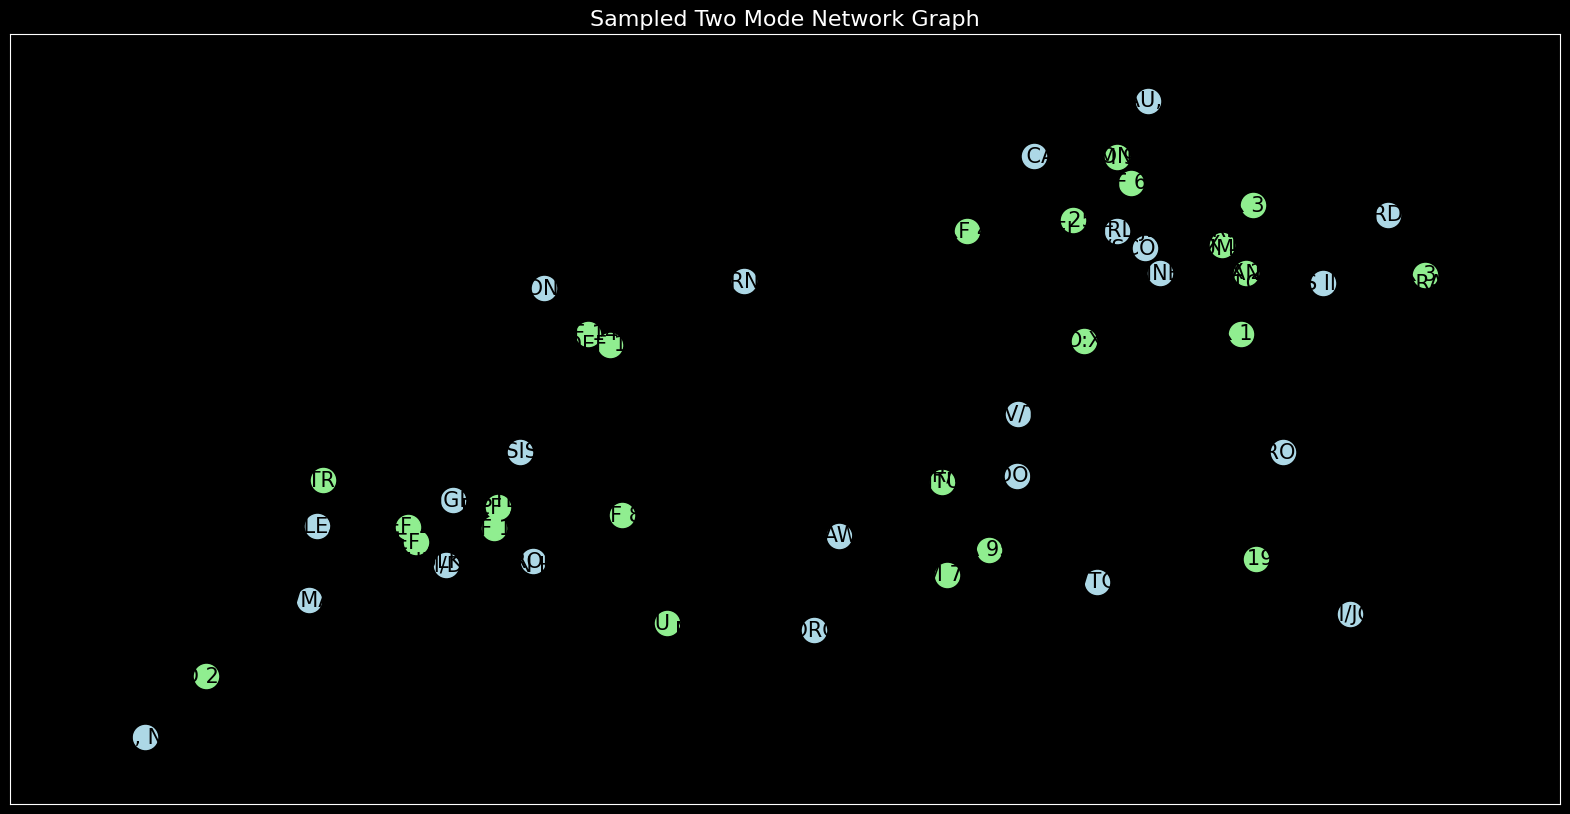

Information for given Graph with name 'Marvel Universe':
	Graph is directed: False
	Number of nodes: 47
	Number of edges: 84


In [278]:
# Randomly select a starting node (either hero or comic)
starting_node = random.choice(list(B.nodes()))

# Perform a random walk to get a sample of the network
sampled_nodes = perform_random_walk(B, starting_node, num_steps=50)

# Create a subgraph with the sampled nodes
sampled_graph = B.subgraph(sampled_nodes)

sampled_heroes_nodes = [node for node in heroes if node in sampled_graph.nodes]
sampled_comics_nodes = [node for node in comics if node in sampled_graph.nodes]

# Draw the sampled graph
plt.figure(figsize=(20, 10))
plt.title("Sampled Two Mode Network Graph", fontsize=16)
draw_graph_and_color_groups(sampled_graph, groups=[sampled_heroes_nodes, sampled_comics_nodes], layout="spring")
plt.show()

print_network_information(sampled_graph)

Das Diagramm zeigt die Stichprobe des Marvel Universe Netzwerks, das aus einem Random Walk mit 50 Schritten resultiert, wobei blaue Knoten Helden repräsentieren, grüne Knoten Comics repräsentieren und die Linien die Verbindungen zwischen ihnen darstellen.

In diesem Netzwerk gibt es keine direkten Verbindungen zwischen Helden oder zwischen Comics untereinander. Stattdessen sind die Helden mit Comics verbunden, was anzeigt, in welchen Comics die jeweiligen Helden erscheinen. Diese Struktur ist typisch für bipartite Netzwerke, in denen die beiden Knotentypen unterschiedliche Entitäten darstellen (in diesem Fall Helden und Comics) und die Kanten die Beziehungen zwischen diesen Entitäten repräsentieren.

### One-Mode-Netzwerk

Da das Netzwerk sehr gross ist, würden die Berechnungen und Darstellungen sehr lange dauern. Deshalb haben wir uns entschieden, das Netzwerk in ein One-Mode-Netzwerk umzuwandeln, in dem die Helden direkt miteinander verbunden sind, wenn sie in mindestens einem Comic gemeinsam auftreten.

In [279]:
# Project the bipartite graph onto heroes nodes using the nodes DataFrame
heroes_nodes = nodes_df[nodes_df['type'] == 'hero']['node'].tolist()

# Project the bipartite graph onto heroes nodes
G_one_mode = bipartite.projected_graph(B, heroes_nodes)

print_network_information(G_one_mode)

Information for given Graph with name 'Marvel Universe':
	Graph is directed: False
	Number of nodes: 6440
	Number of edges: 171644


Das One-Mode Netzwerk besteht nun aus 6'440 Knoten, die jeweils einen Helden darstellen. Es gibt 171'644 Kanten im Graphen, wobei jede Kante einen gemeinsamen Comic-Auftritt zwischen zwei Helden anzeigt.

Dazu werden wir auch nur die 100 am häufigsten vorkommenden Helden berücksichtigen, um die Berechnungen zu beschleunigen. 

In [280]:
top_heroes = edges_df['hero'].value_counts().head(100).index.tolist()
top_heroes[:5]

['SPIDER-MAN/PETER PARKER',
 'CAPTAIN AMERICA',
 'IRON MAN/TONY STARK',
 'THING/BENJAMIN J. GR',
 'THOR/DR. DONALD BLAK']

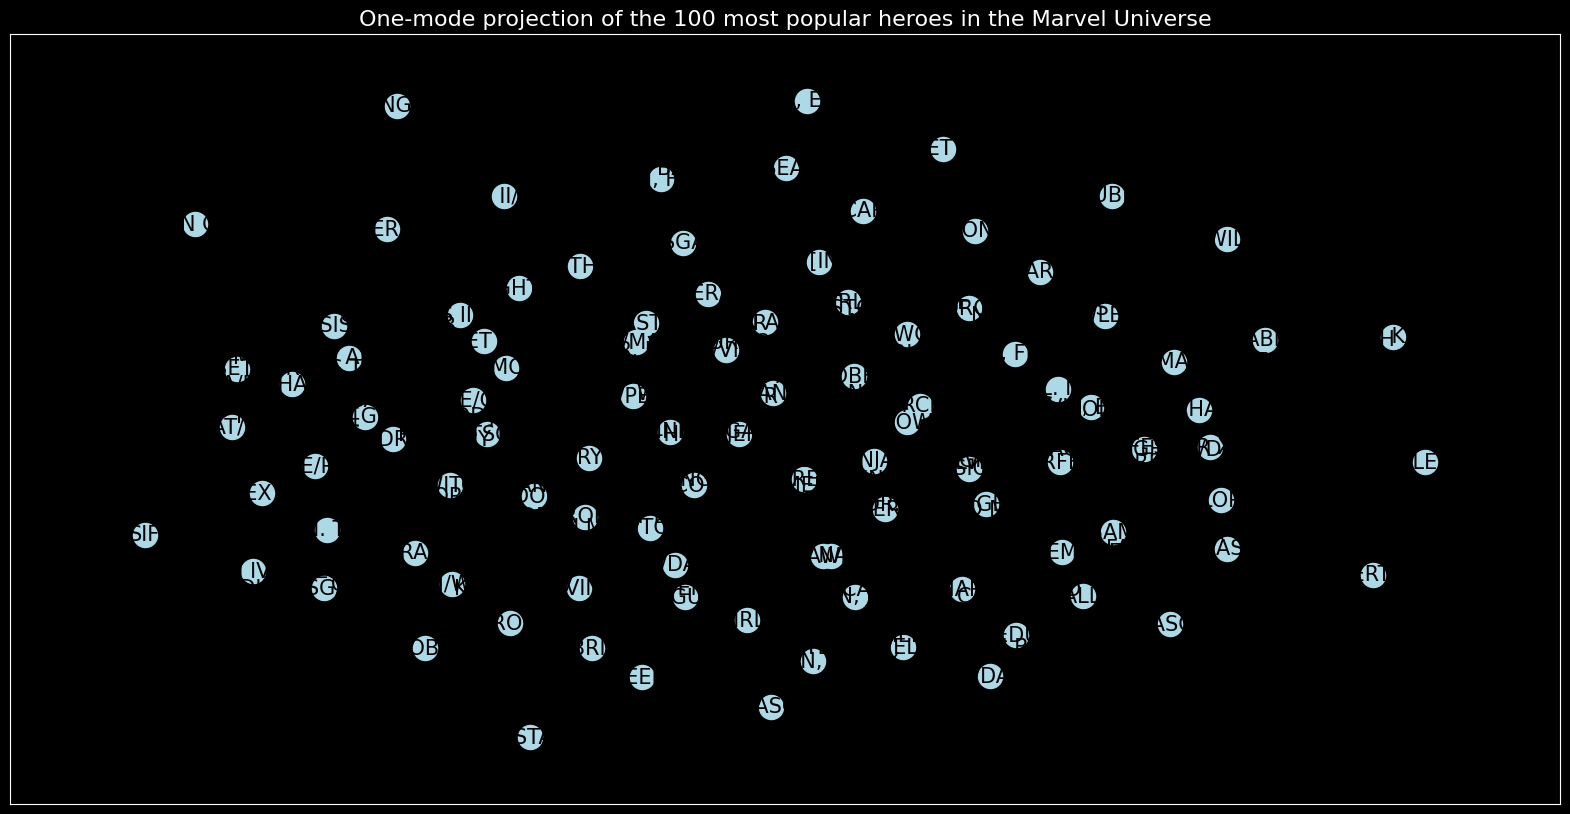

Information for given Graph with name 'Marvel Universe':
	Graph is directed: False
	Number of nodes: 100
	Number of edges: 4076


In [281]:
# Filter the one-mode network to only include the top 100 heroes
top_heroes_subgraph = G_one_mode.subgraph(top_heroes)

# Draw the projected graph
plt.figure(figsize=(20, 10))
plt.title("One-mode projection of the 100 most popular heroes in the Marvel Universe", fontsize=16)
draw_graph_and_color_groups(top_heroes_subgraph, layout="spring")
plt.show()

print_network_information(top_heroes_subgraph)

Wir sehen, dass die 100 am häufigsten vorkommenden Helden sehr stark vernetzt sind. Es gibt viele sehr zentrale Helden. Sie könnten als Schlüsselfiguren oder Hauptcharaktere im Marvel-Universum betrachtet werden.

Da wir nun unsere verschiedenen Netzwerke erstellt haben, können wir mit der Analyse beginnen. 

## Frage 1 - Welche Helden sind die zentralsten im Netzwerk?

Um die Frage zu beantworten, welche Helden die zentralsten im Netzwerk sind, werden wir die drei genannten Zentralitätsmasse verwenden: Degree-Centrality, Betweenness-Centrality und Closeness-Centrality. Diese Masse geben jeweils unterschiedliche Aspekte der Zentralität eines Knotens im Netzwerk an:

- Degree-Centrality misst die Anzahl der direkten Verbindungen, die ein Knoten hat. Für Helden in unserem Netzwerk bedeutet ein hoher Wert, dass sie in vielen verschiedenen Comics erscheinen.

- Betweenness-Centrality gibt an, wie oft ein Knoten auf den kürzesten Pfaden zwischen anderen Knoten liegt. Ein hoher Wert deutet darauf hin, dass der Held eine wichtige Rolle in der Verbindung verschiedener Teile des Netzwerks spielt.

- Closeness-Centrality misst, wie nahe ein Knoten im Durchschnitt zu allen anderen Knoten im Netzwerk liegt. Ein hoher Wert zeigt an, dass ein Held im Durchschnitt schneller mit anderen Knoten verbunden werden kann.

### Ganzes Netzwerk
Beachte: Die Laufzeit der Betweenness und Closeness Zentralitäten dauern jeweils 3.5 und 1 Minute.

In [282]:
# Degree
degree_centrality = nx.degree_centrality(G_one_mode)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print_centrality(top_degree_centrality, "Helden mit der höchsten Degree-Zentralität")

Helden mit der höchsten Degree-Zentralität:
  CAPTAIN AMERICA: 0.2980
  SPIDER-MAN/PETER PARKER: 0.2724
  IRON MAN/TONY STARK: 0.2432
  THING/BENJAMIN J. GR: 0.2249
  MR. FANTASTIC/REED R: 0.2199



In [283]:
# Betweenness
betweenness_centrality = nx.betweenness_centrality(G_one_mode)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print_centrality(top_betweenness_centrality, "Helden mit der höchsten Betweenness-Zentralität")

KeyboardInterrupt: 

In [284]:
# Closeness
closeness_centrality = nx.closeness_centrality(G_one_mode)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print_centrality(top_closeness_centrality, "Helden mit der höchsten Closeness-Zentralität")

KeyboardInterrupt: 

Helden mit der höchsten Degree-Zentralität, wie Captain America und Spider-Man, sind also diejenigen, die mit den meisten anderen Helden direkt verbunden sind. Sie sind möglicherweise die beliebtesten und aktivsten Charaktere, die in einer grossen Anzahl von Comics mit verschiedenen anderen Helden erscheinen.

Spider-Man hat hier die höchste Betweenness-Zentralität, was darauf hindeutet, dass er eine wichtige "Brückenfigur" im Marvel-Universum ist, die verschiedene Gruppen oder Gemeinschaften von Helden miteinander verbindet. Er könnte in vielen Storylines eine zentrale Rolle spielen, die unterschiedliche Helden zusammenführt.

Captain America und Spider-Man haben auch hier die höchsten Werte, was bedeutet, dass sie im Durchschnitt die kürzesten Pfade zu allen anderen Helden im Netzwerk haben. Dies deutet auf ihre zentrale Stellung in der "sozialen Struktur" des Marvel-Universums hin.

### Top 100 Helden Netzwerk

In [285]:
# Degree
degree_centrality_top_100 = nx.degree_centrality(top_heroes_subgraph)
top_degree_centrality_top_100 = sorted(degree_centrality_top_100.items(), key=lambda x: x[1], reverse=True)
print_centrality(top_degree_centrality_top_100, "Helden mit der höchsten Degree-Zentralität")

Helden mit der höchsten Degree-Zentralität:
  MR. FANTASTIC/REED R: 1.0000
  CYCLOPS/SCOTT SUMMER: 1.0000
  HUMAN TORCH/JOHNNY S: 1.0000
  CAPTAIN AMERICA: 1.0000
  WOLVERINE/LOGAN: 1.0000



In [286]:
# Betweenness
betweenness_centrality_top_100 = nx.betweenness_centrality(top_heroes_subgraph)
top_betweenness_centrality_top_100 = sorted(betweenness_centrality_top_100.items(), key=lambda x: x[1], reverse=True)
print_centrality(top_betweenness_centrality_top_100, "Helden mit der höchsten Betweenness-Zentralität")

Helden mit der höchsten Betweenness-Zentralität:
  MR. FANTASTIC/REED R: 0.0037
  CYCLOPS/SCOTT SUMMER: 0.0037
  HUMAN TORCH/JOHNNY S: 0.0037
  CAPTAIN AMERICA: 0.0037
  WOLVERINE/LOGAN: 0.0037



In [287]:
# Closeness
closeness_centrality_top_100 = nx.closeness_centrality(top_heroes_subgraph)
top_closeness_centrality_top_100 = sorted(closeness_centrality_top_100.items(), key=lambda x: x[1], reverse=True)
print_centrality(top_closeness_centrality_top_100, "Helden mit der höchsten Closeness-Zentralität")

Helden mit der höchsten Closeness-Zentralität:
  MR. FANTASTIC/REED R: 1.0000
  CYCLOPS/SCOTT SUMMER: 1.0000
  HUMAN TORCH/JOHNNY S: 1.0000
  CAPTAIN AMERICA: 1.0000
  WOLVERINE/LOGAN: 1.0000



Jeder dieser Helden hat eine Degree-Zentralität und Closeness-Zentralität von 1, was bedeutet, dass sie alle mit jedem anderen Helden im Netzwerk direkt verbunden sind. Die Betweenness-Zentralität ist für alle fünf Helden identisch und ziemlich niedrig, was wiederum die hohe Dichte des Netzwerks und die geringe Notwendigkeit von "Brücken"-Helden in diesem Netzwerk anzeigt.

Da wir jetzt wissen, welche Helden die zentralsten sind, wollen wir weitere Analysen auf diesen Hauptcharakteren durchführen.

### Verbindung zwischen Captain America, Iron Man und Spiderman

Wir haben herausgefunden, dass Captain America, Ironman und Spider-Man im `hero-network.csv` die meisten Verbindungen haben. Wir wollen nun herausfinden, wie die anderen Helden mit unseren "Haupt-Helden" verbunden sind und welche Helden nur auf einen, mit zwei oder drei "Haupt-Helden" verbunden sind.

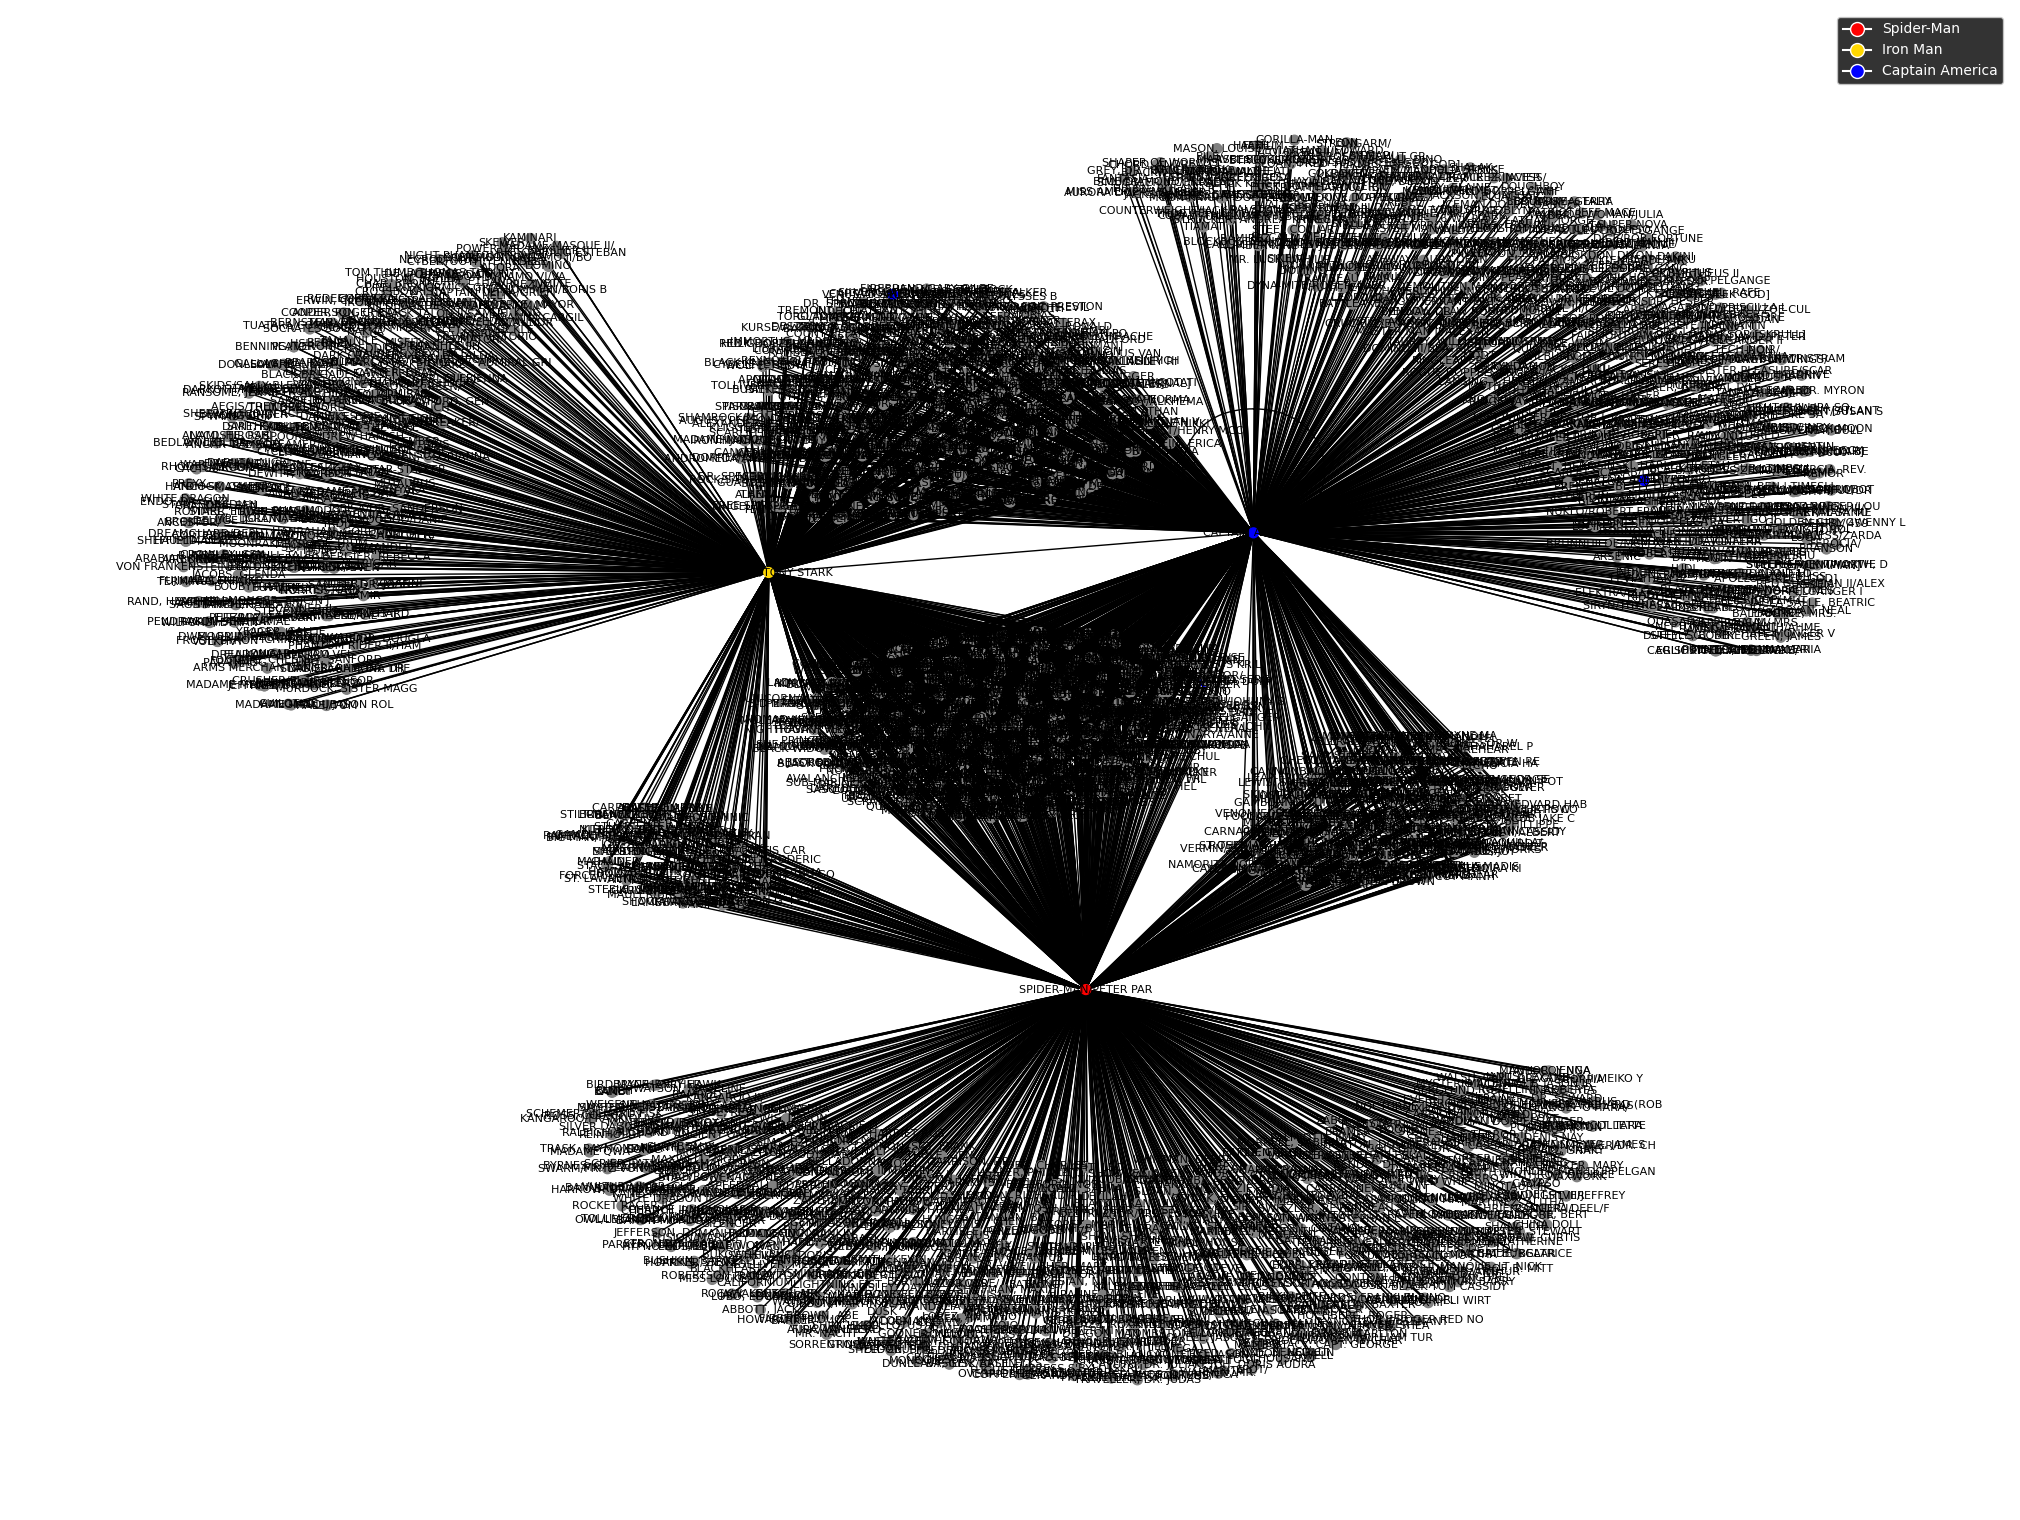

In [288]:
# connection between captain america,ironman and spiderman
captAmerica = Subset = hero_network[hero_network['hero1'] == 'CAPTAIN AMERICA']
ironMan = hero_network[hero_network['hero1'].str.contains('IRON MAN/TONY STARK')]
spiderMan = hero_network[hero_network['hero1'].str.contains('SPIDER-MAN/PETER PAR')]
Subset = pd.concat([captAmerica, ironMan, spiderMan], axis=0)

G = nx.from_pandas_edgelist(Subset, 'hero1', 'hero2')

node_colors = []

for node in G.nodes():
    if 'SPIDER-MAN/PETER PAR' in node:
        node_colors.append('red')  # Spider-Man in Rot
    elif 'IRON MAN/TONY STARK' in node:
        node_colors.append('gold')  # Iron Man in Gold
    elif 'CAPTAIN AMERICA' in node:
        node_colors.append('blue')  # Captain America in Blau
    else:
        node_colors.append('grey')  # Alle anderen Knoten in Grau
        
plt.figure(figsize=(20, 15))
nx.draw(G, node_color=node_colors, with_labels=True, node_size=50, font_size=8)

# Create a legend
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Spider-Man', markersize=10, markerfacecolor='red')
gold_patch = plt.Line2D([0], [0], marker='o', color='w', label='Iron Man', markersize=10, markerfacecolor='gold')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Captain America', markersize=10, markerfacecolor='blue')
plt.legend(handles=[red_patch, gold_patch, blue_patch])

plt.show()

Wir sehen, dass Captain America und Spider Man sehr viele einzelne Verbindungen zu Helden haben. Es gibt auch sehr viele Helden, welche eine Verbingung zu allen 3 "Haupt-Helden" haben. Dies sieht man anhand des grossen Clusters in der Mitte des Netzwerkes. Zudem ist gut zu erkennen, dass es es sehr wenige Helden gibt, die nur zu Iron Man und Spider Man verbunden sind (Also kein Captain America). Viel mehr sind zusammen mit Spider Man und Captain America oder Iron Man zu Captain America verbunden.

Diese Visualisierung dient zur Veranschaulichung der Wichtigkeit der "Haupt-Helden". Es zeigt, dass die Haupt-Helden sehr viele Verbindungen zu anderen Helden haben und somit eine wichtige Rolle im Marvel-Universum spielen.

Um das angewendete Prizip ein bisschen besser anzusehen, visualisieren wir im folgenden Plot noch eine vereinfachte Version des Netzwerkes mit 25 samples pro "Haupt-Held".

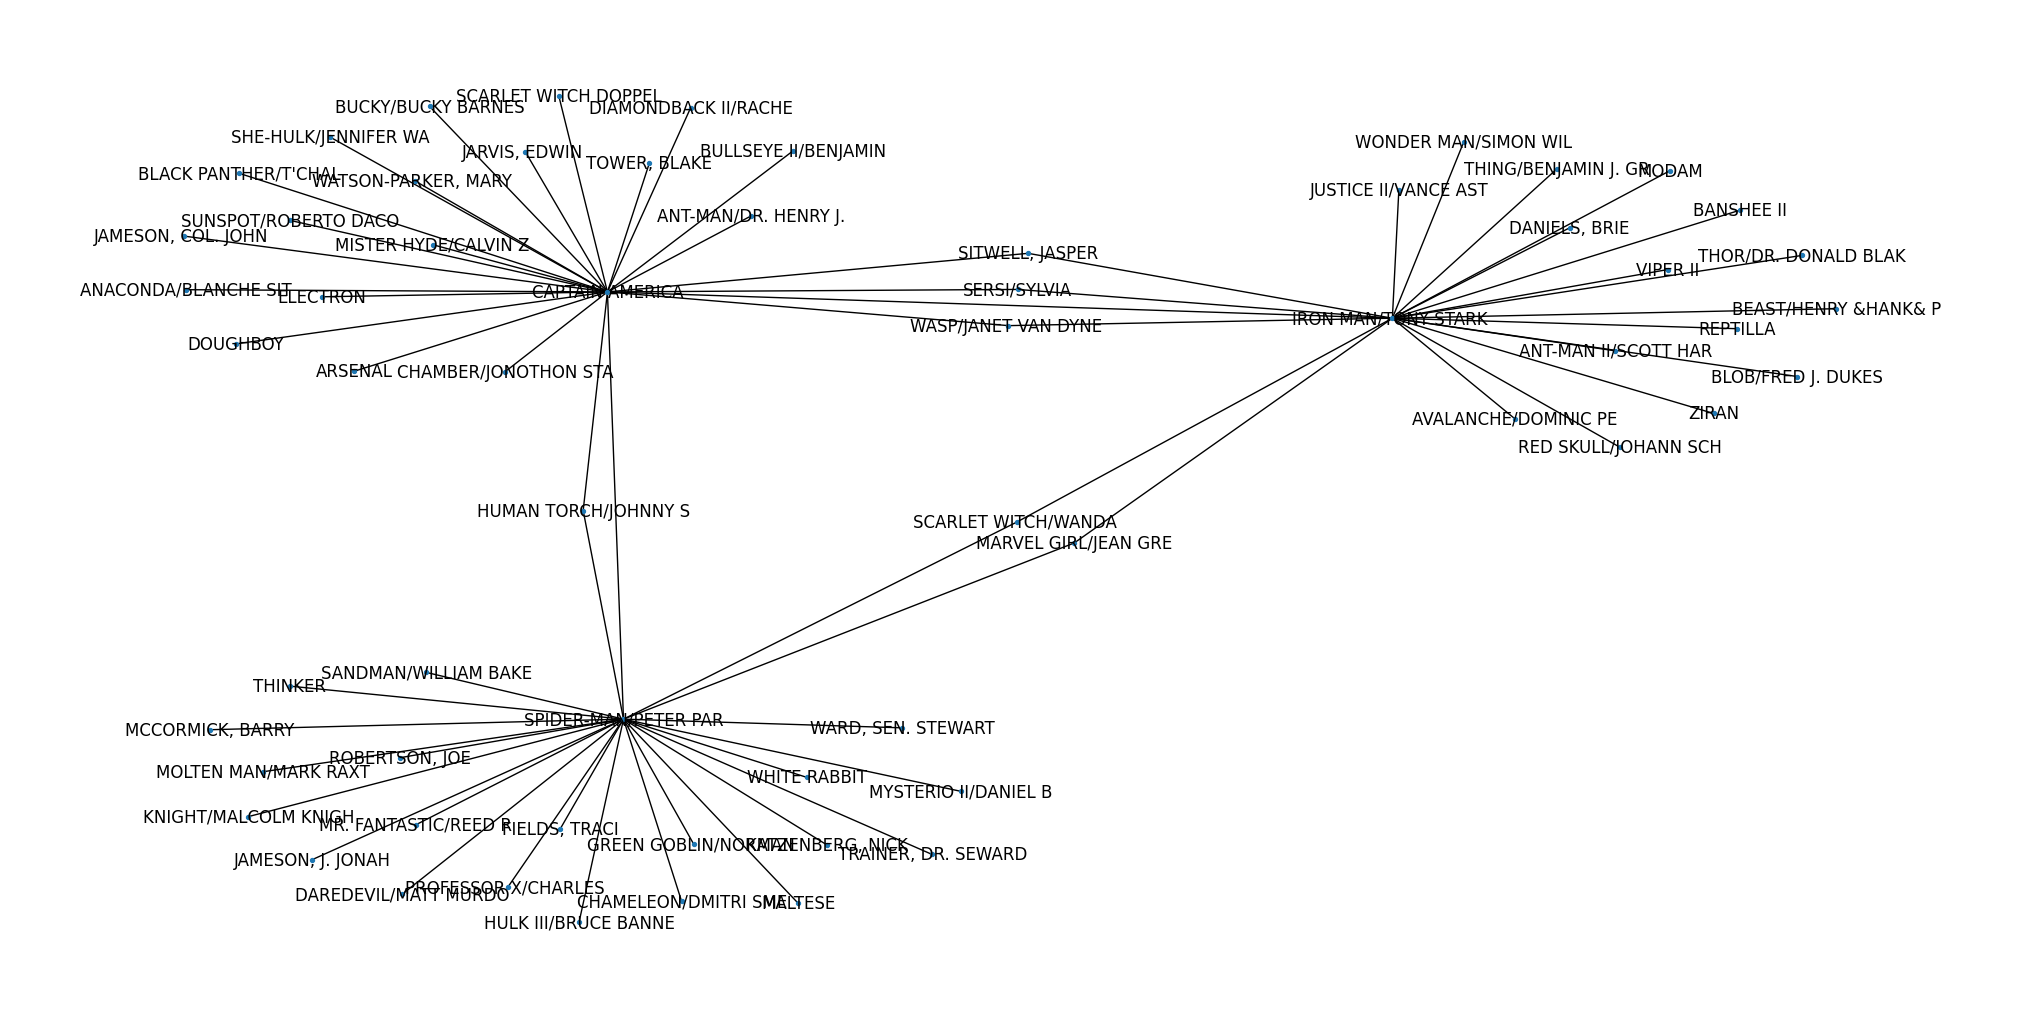

In [289]:
# connection between captain america,ironman and spiderman
captAmerica_sample = Subset_sample = hero_network[hero_network['hero1'] == 'CAPTAIN AMERICA'].sample(25)
ironMan_sample = hero_network[hero_network['hero1'].str.contains('IRON MAN/TONY STARK')].sample(25)
spiderMan_sample = hero_network[hero_network['hero1'].str.contains('SPIDER-MAN/PETER PAR')].sample(25)
Subset_sample = pd.concat([captAmerica_sample, ironMan_sample, spiderMan_sample], axis=0)

G = nx.from_pandas_edgelist(Subset_sample, 'hero1', 'hero2')

plt.figure(figsize=(20, 10))
nx.draw(G, with_labels=True, node_size=8)
plt.show()

Die vereinfachte Ansicht, gibt uns eine gute Übersicht. Je nach seed sehen wir, wie auch schon in der gesamt Ansicht, dass Captain America mehrmals vorkommen muss. Dieses haben wir bereits in der Explorativen Datenanalyse gemacht. 

Uns interessiert aber vorerst die genaue Anzahl der Verbindungen. Dazu erstellen wir eine Tabelle mit den Anzahl Verbindungen zu den "Haupt-Helden". Die "mehrfachen Captain America's" analysieren wir danach. 

#### Anzahl Verbindungen zu den "Haupt-Helden"

In [290]:
# To create the table as requested, we need to count the connections based on the criteria given.
# We will assume that the hero_network dataframe has already been loaded as per previous code snippets.

# Counting connections for each main hero
capt_america_count = captAmerica['hero2'].nunique()
iron_man_count = ironMan['hero2'].nunique()
spiderman_count = spiderMan['hero2'].nunique()

# Counting mutual connections
capt_america_iron_man = hero_network[(hero_network['hero1'] == 'CAPTAIN AMERICA') & 
                                      hero_network['hero2'].str.contains('IRON MAN/TONY STARK')].shape[0]
capt_america_spiderman = hero_network[(hero_network['hero1'] == 'CAPTAIN AMERICA') & 
                                       hero_network['hero2'].str.contains('SPIDER-MAN/PETER PAR')].shape[0]
iron_man_spiderman = hero_network[(hero_network['hero1'].str.contains('IRON MAN/TONY STARK')) & 
                                  hero_network['hero2'].str.contains('SPIDER-MAN/PETER PAR')].shape[0]

# Counting connections between all three
all_three_connections = hero_network[(hero_network['hero1'].str.contains('CAPTAIN AMERICA') & 
                                      hero_network['hero2'].str.contains('IRON MAN/TONY STARK')) |
                                     (hero_network['hero1'].str.contains('IRON MAN/TONY STARK') & 
                                      hero_network['hero2'].str.contains('SPIDER-MAN/PETER PAR')) |
                                     (hero_network['hero1'].str.contains('CAPTAIN AMERICA') & 
                                      hero_network['hero2'].str.contains('SPIDER-MAN/PETER PAR'))].shape[0]

# Creating the table
table_data = {
    'Connection': ['Captain America', 'Captain America - Spiderman', 'Captain America - Iron Man',
                   'Iron Man', 'Iron Man - Spiderman', 'Spiderman', 
                   'Captain America - Iron Man - Spiderman'],
    'Number of Connections': [capt_america_count, capt_america_spiderman, capt_america_iron_man,
                              iron_man_count, iron_man_spiderman, spiderman_count,
                              all_three_connections]
}

connection_table = pd.DataFrame(table_data)

connection_table.sort_values(by='Number of Connections', ascending=False)

Connection  Number of Connections
0                         Captain America                   1426
5                               Spiderman                   1286
3                                Iron Man                   1132
6  Captain America - Iron Man - Spiderman                    353
2              Captain America - Iron Man                    220
1             Captain America - Spiderman                     79
4                    Iron Man - Spiderman                     54

Diese Tabelle bestätigt unsere vorherige Aussage. Es gibt sehr viele Helden, welche mit allen drei "Haupt-Helden" verbunden sind. Es gibt aber auch sehr viele Helden, welche nur mit einem oder zwei "Haupt-Helden" verbunden sind. 

Jeder Haupt-Held hat mehr als 1000 Verbindungen zu anderen einzelnen Helden. Dies zeigt, dass die Haupt-Helden mehr Verbindungen zu einzelnen Helden haben statt mit gemeinsamen Helden. Sie spielen also eine zentrale Rolle im Marvel-Universum. 

#### Gemeinsame Comics von Captain America, Iron Man und Spiderman 

In [291]:
# identify names of Captain America, Iron Man und Spider-Man
captain_america_names = [name for name in nodes_df[nodes_df['type'] == 'hero']['node'] if 'CAPTAIN AMERICA' in name]
iron_man_names = [name for name in nodes_df[nodes_df['type'] == 'hero']['node'] if 'IRON MAN' in name]
spider_man_names = [name for name in nodes_df[nodes_df['type'] == 'hero']['node'] if 'SPIDER-MAN' in name]

# find comics with these names
captain_america_comics = edges_df[edges_df['hero'].isin(captain_america_names)]['comic'].unique()
iron_man_comics = edges_df[edges_df['hero'].isin(iron_man_names)]['comic'].unique()
spider_man_comics = edges_df[edges_df['hero'].isin(spider_man_names)]['comic'].unique()

# find common comics
common_comics = set(captain_america_comics) & set(iron_man_comics) & set(spider_man_comics)

# Anzahl und Liste der gemeinsamen Comics
print(f" shared comics: {len(common_comics)} | {common_comics}")

 shared comics: 3 | {'ASM2 1', 'A 400', 'SMTU 4'}


Comic Namen:
- A 400   :  AVENGERS 400
- SMTU 4  : Spider-Man Team-Up 4
- ASM2 1  : Amazing Spider-Man 2 

In diesen 3 Comics, kommen alle 3 zentralsten Helden vor. Dies ist für uns überaschend, da wir dachten, dass es mehr Comics gibt, in denen alle 3 Helden vorkommen.

## Frage 2 - Wie ist die Verteilung der Anzahl der Comics pro Held?

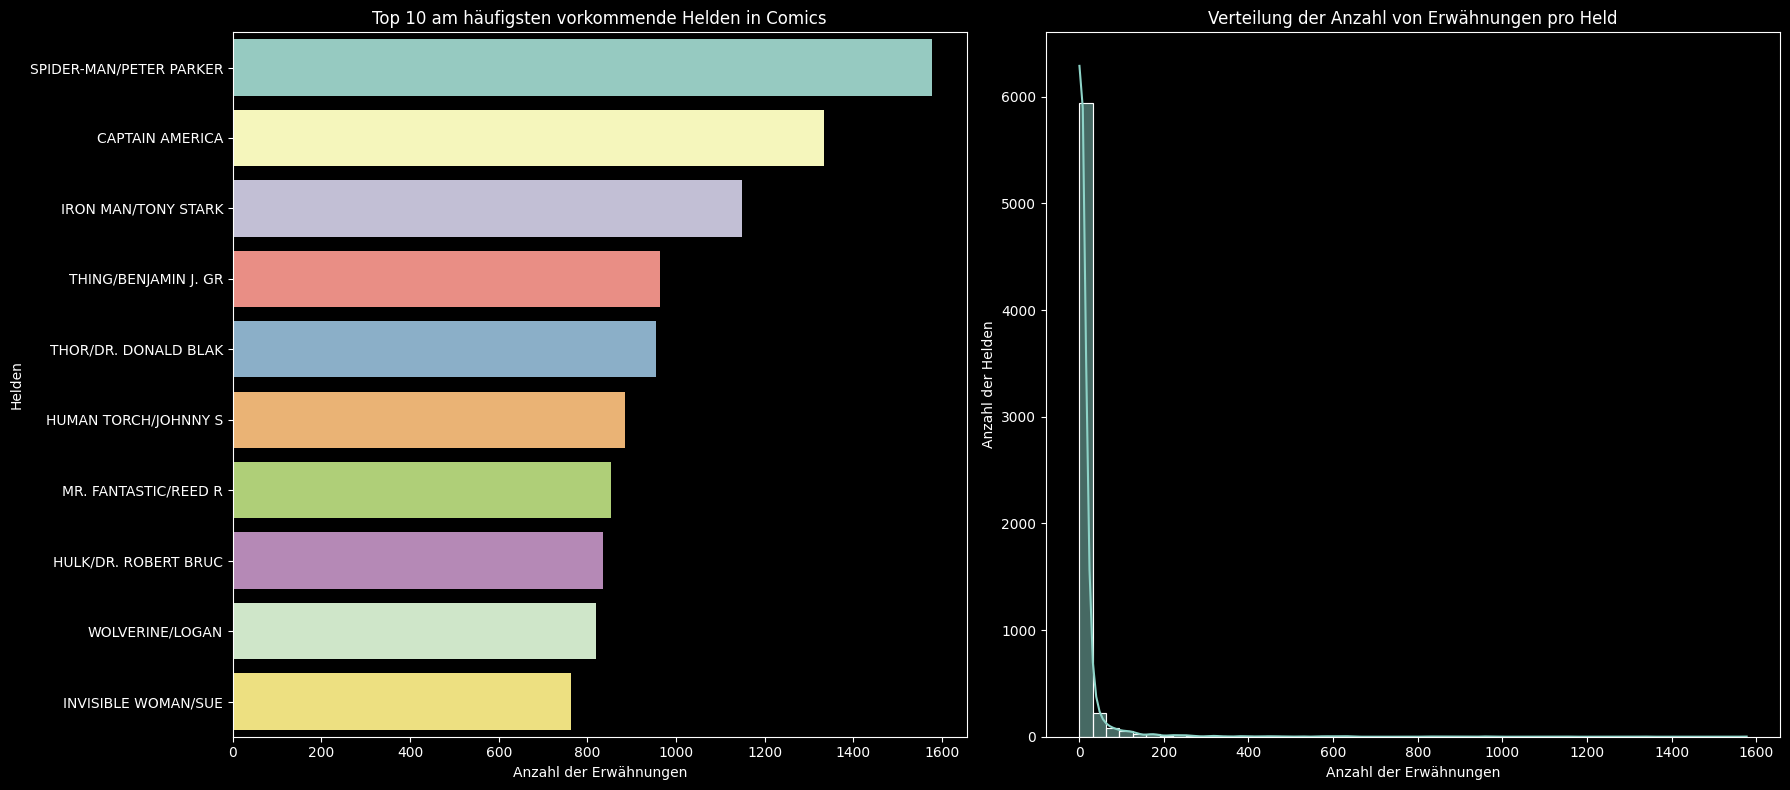

In [292]:
# Count the number of mentions for each hero
hero_mentions = edges_df['hero'].value_counts()
top_heroes = hero_mentions.head(10)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Top 10 most frequent comics
sns.barplot(x=top_heroes.values, y=top_heroes.index, ax=axes[0])
axes[0].set_title('Top 10 am häufigsten vorkommende Helden in Comics')
axes[0].set_xlabel('Anzahl der Erwähnungen')
axes[0].set_ylabel('Helden')

# Distribution plot of mentions per comic
sns.histplot(hero_mentions, bins=50, kde=True, ax=axes[1])
axes[1].set_title('Verteilung der Anzahl von Erwähnungen pro Held')
axes[1].set_xlabel('Anzahl der Erwähnungen')
axes[1].set_ylabel('Anzahl der Helden')

plt.tight_layout()
plt.show()

## Frage 3 - Gibt es Gruppen oder Gemeinschaften von Helden, die häufig zusammen in Comics erscheinen?

Für die Community-Detection verwenden wir die [Greedy-Modularity-Methode](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html). Der Algorithmus basiert auf der Maximierung der Modularity über alle möglichen Partitionen des Netzwerks. Modularity ist ein Mass, das die Dichte der Kanten innerhalb von Gemeinschaften im Vergleich zu einer zufälligen Verteilung von Kanten bewertet. Wenn die Modularity eines bestimmten Netzwerks höher ist als die eines zufälligen Netzwerks, deutet dies auf eine strukturierte Gemeinschaftsbildung hin.

Ziel ist es, ein Verständnis über verschiedene Gruppen von Helden zu erhalten, die häufig zusammen in Comics auftreten. Hierzu werden wir die Kantengewichtung hervorheben, um die Stärke der Verbindung zwischen den Helden in einem Community zu visualisieren. Dazu werden wir die Kantengewichtung auf die Dicke der Kanten abbilden. Wir werden auch die Edge-Betweenness bei den gefundenen Communities berechnen, um zu sehen, welche Kanten die wichtigsten sind, um die Gemeinschaften zusammenzuhalten.

### Ganzes Netzwerk

#### Gemeinschaften

In [293]:
communities = get_communities(G_one_mode, "Helden")

Gemeinschaft 1: ['8-BALL/', 'A', "A'YIN", 'ABBOTT, JACK', 'ABCISSA', 'ABEL', 'ABSALOM', 'ACHEBE, REVEREND DOC', 'ADAM X', 'ADAMS, CONGRESSMAN H'] ... [2756 Helden]
Gemeinschaft 2: ['3-D MAN/CHARLES CHAN', '4-D MAN/MERCURIO', 'ABOMINATION/EMIL BLO', 'ABOMINATRIX', 'ABSORBING MAN/CARL C', 'ACBA', 'ACHILLES II/HELMUT', 'ACROBAT/CARL ZANTE', 'ADAMS, CINDY', 'ADAMS, GEORGE'] ... [2511 Helden]
Gemeinschaft 3: ['ADAMSON, JASON', 'ADAMSON, REBECCA', 'AENTAROS', 'AGENT 18/JACK TRUMAN', 'ALIST', 'ANDERSON, GINA', 'AUSTIN, GEN.', 'AXIS/', 'AZAZEL', 'BELGRADE, DR. HORATI'] ... [171 Helden]
Gemeinschaft 4: ['ABOMINATION | MUTANT', 'ABSORBING MAN | MUTA', 'ANCIENT ONE/BARON MO', 'APOCALYPSE | MUTANT', 'AURORA | MUTANT X-VE', 'BETA RAY BILL | MUTA', 'BEYONDER | MUTANT X-', 'BINARY | MUTANT X-VE', 'BLACK BOLT | MUTANT', 'BLACK PANTHER | MUTA'] ... [117 Helden]
Gemeinschaft 5: ['AQUARIUS III/', 'ARIES III/', 'ARKANIAN, GLIB', 'BARON ZEBEK', 'BAV-TEK', 'BECKLEY, BENNY', 'BEL-DANN, GEN.', 'BRASS BISHOP/'

In unserem Netzwerk gibt es total 118 Gemeinschaften. Die grösste Gemeinschaft besteht aus 2'756 Helden, die kleinste aus 1 Held.

Da es recht viele Gemeinschaften gibt, werden wir uns auf 2-3 Gemeinschaften konzentrieren.

#### Community 3

Visualisieren wir zuerst die dritte Gemeinschaft, wobei wir die Kantengewichtung hervorheben.

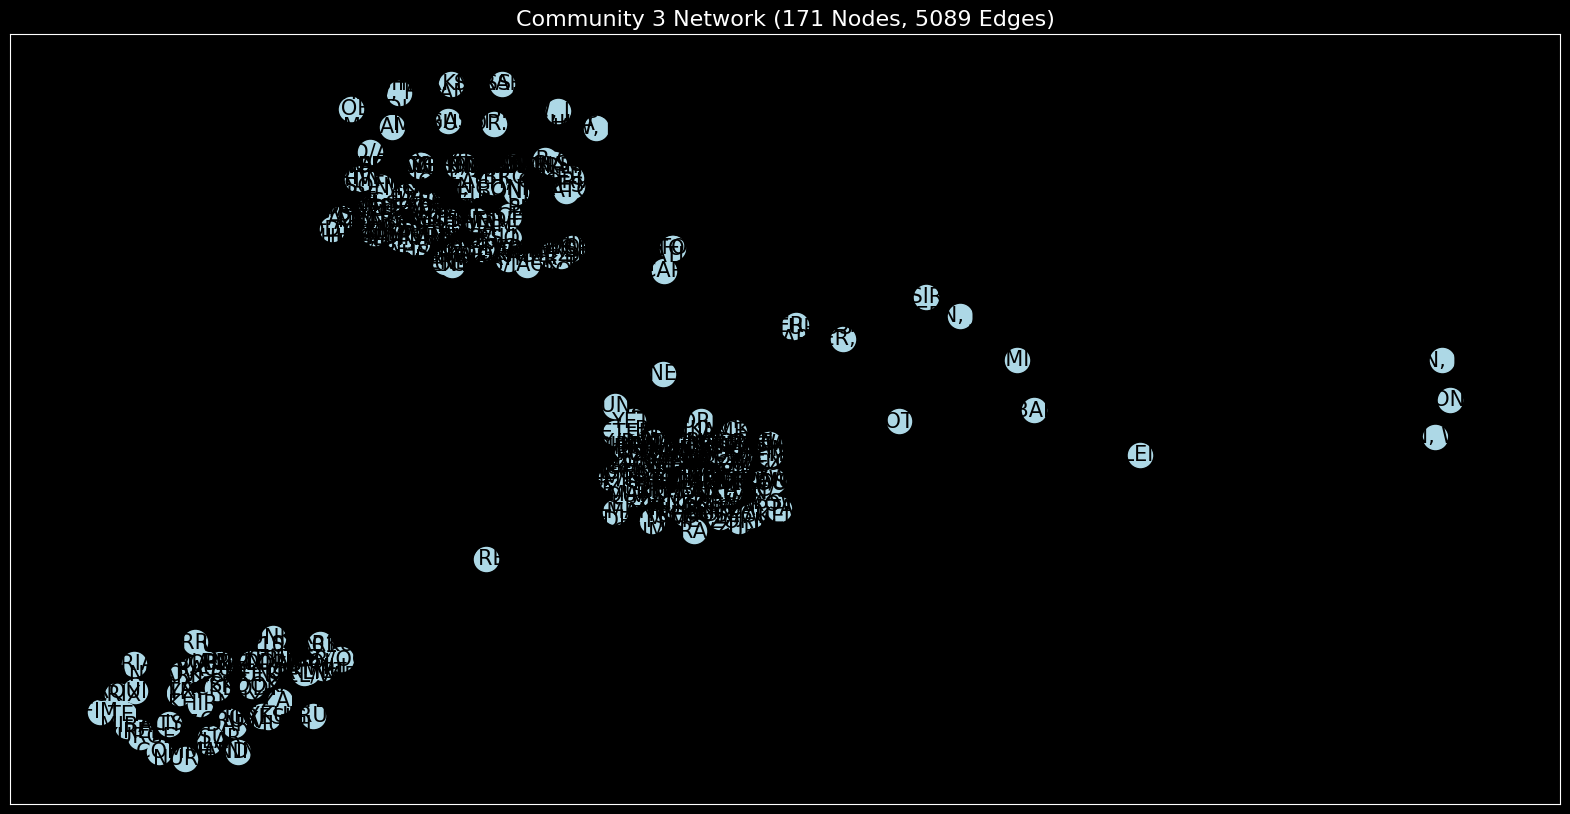

Top 10 Kantengewichte der Helden in der Community 3:
PIXIE/ [ETERNAL] - BLACK FOX/ROBERT W.: 76
EFFIGY/LT. VELMAX/JA - BLACK FOX/ROBERT W.: 75
EFFIGY/LT. VELMAX/JA - PIXIE/ [ETERNAL]: 74
EFFIGY/LT. VELMAX/JA - MR. JUSTICE/TIMOTHY: 72
MR. JUSTICE/TIMOTHY - PIXIE/ [ETERNAL]: 72
MR. JUSTICE/TIMOTHY - BLACK FOX/ROBERT W.: 72
EFFIGY/LT. VELMAX/JA - OXBOW/: 63
LOCKE, DR. CASSANDRA - PIXIE/ [ETERNAL]: 63
PIXIE/ [ETERNAL] - OXBOW/: 63
PIXIE/ [ETERNAL] - YETI: 62


In [294]:
plot_community(G_one_mode, communities, 2)

Interessanterweise sehen wir in diesem Community weitere Gruppierungen von Helden.

##### Edge Betweenness

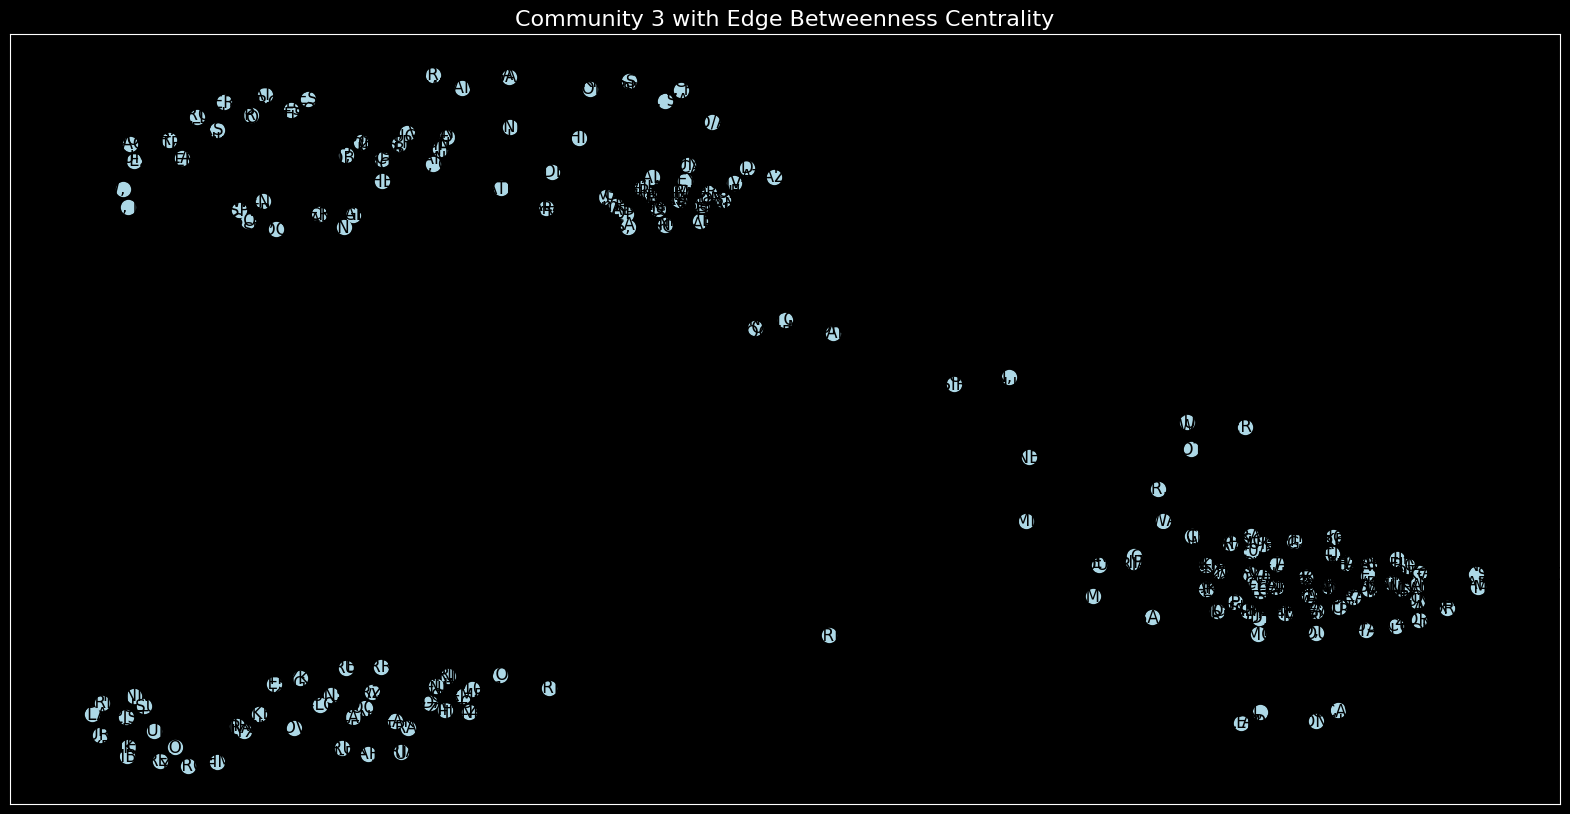

Top 10 Edges by Edge Betweenness Centrality in Community 3:
('MERRYWEATHER, IRENE', 'BLOODSTONE/ULYSSES B'): 0.4479
('UNI-LORD', 'VYREK'): 0.0982
('BLOODSTONE/ULYSSES B', 'BLACK FOX/ROBERT W.'): 0.0971
('EFFIGY/LT. VELMAX/JA', 'BLOODSTONE/ULYSSES B'): 0.0944
('NIGHTINGALE/', 'BLOODSTONE/ULYSSES B'): 0.0731
('DARK COUNSEL/VARTU', 'VYREK'): 0.0712
('VYREK', 'BLACK FOX/ROBERT W.'): 0.0569
('KABALLA', 'BLOODSTONE/ULYSSES B'): 0.0561
('EFFIGY/LT. VELMAX/JA', 'VYREK'): 0.0555
('NIGHTINGALE/', 'VYREK'): 0.0507


In [295]:
plot_community_edge_betweenness(G_one_mode, communities, 2)

Wie beim oberen Plot sehen wir kleinere Gruppierungen im Community. Mittels Edge Betweenness können wir jedoch die Verbindungen zwischen den einzelnen Gruppierungen viel besser sehen. Die dicksten Kanten sind diejenigen, die die einzelnen Gruppierungen zusammenhalten.

die Kante 'MERRYWEATHER, IRENE', 'BLOODSTONE/ULYSSES B' hat bei weitem die höchste Edge Betweenness und wir sehen ihre Wichtigkeit in der Visualisierung, wie sie das Netzwerk zusammenhält.

#### Community 7

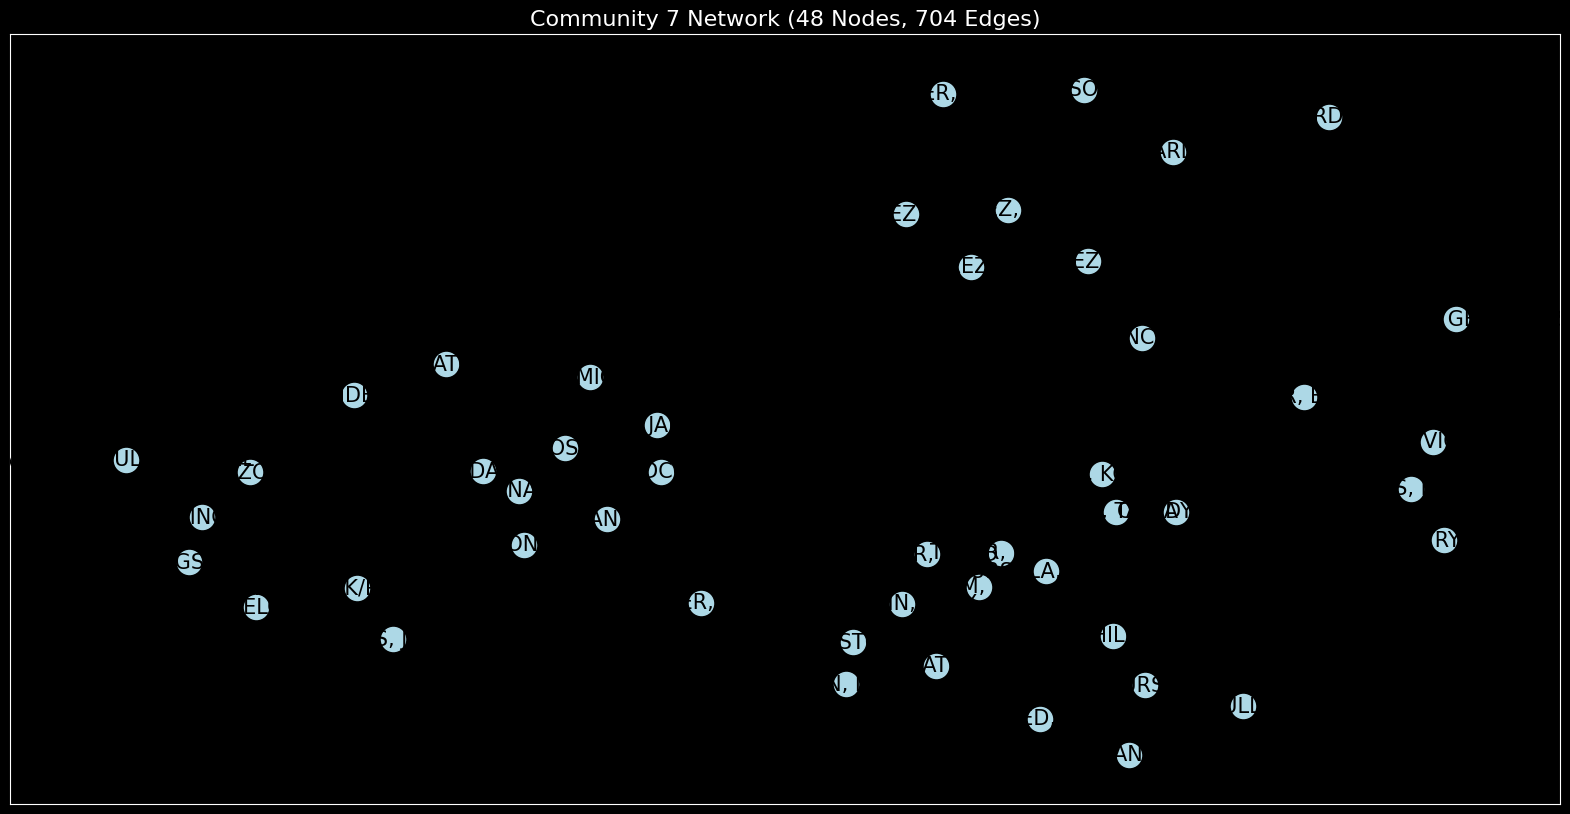

Top 10 Kantengewichte der Helden in der Community 7:
GATOR, LORD - RAM, SIR: 79
GATOR, LORD - URSULA, LADY: 75
URSULA, LADY - RAM, SIR: 75
GATOR, LORD - TYGER, LORD: 71
TYGER, LORD - RAM, SIR: 71
URSULA, LADY - TYGER, LORD: 67
VERMIN, LADY - GATOR, LORD: 63
VERMIN, LADY - TYGER, LORD: 63
VERMIN, LADY - RAM, SIR: 63
VERMIN, LADY - URSULA, LADY: 59


In [296]:
plot_community(G_one_mode, communities, 6)

##### Edge Betweenness

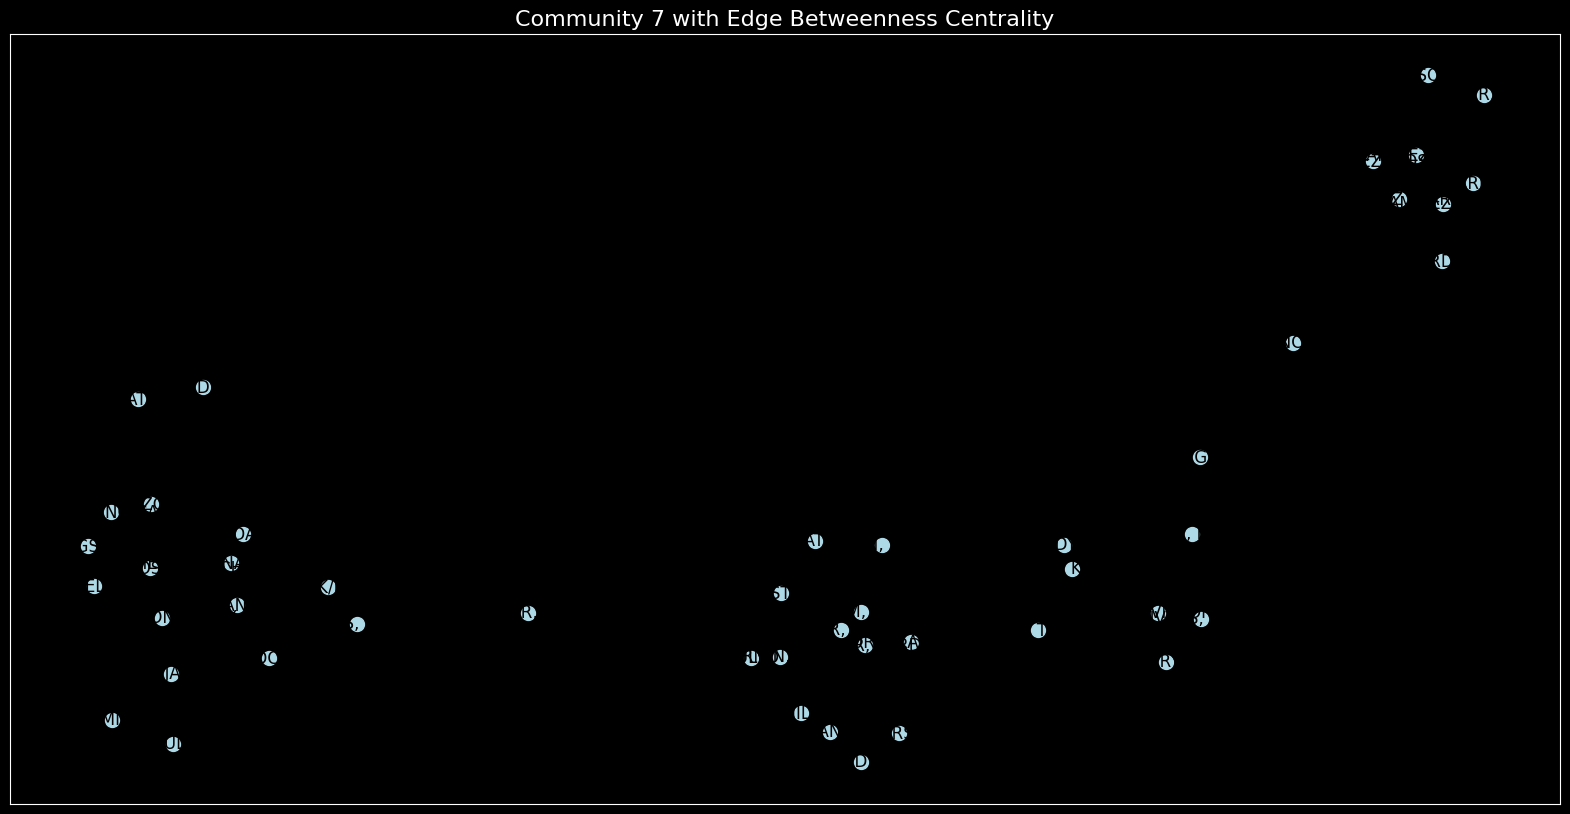

Top 10 Edges by Edge Betweenness Centrality in Community 7:
('STRYKER, WILLIS', 'GATOR, LORD'): 0.1423
('STRYKER, WILLIS', 'RAM, SIR'): 0.1423
('STRYKER, WILLIS', 'TYGER, LORD'): 0.1423
('BOLT, COUNCILMAN AND', 'LOR, KONA'): 0.1423
('BOLT, COUNCILMAN AND', 'CIR, DYLON'): 0.1423
('MEDINA, ANALISA MARI', 'STRYKER, WILLIS'): 0.1246
('ANDREWS, DARYL TROOP', 'STRYKER, WILLIS'): 0.1108
('STRYKER, WILLIS', 'POWER MAN III/STEELE'): 0.0971
('HARDCORE/', 'STRYKER, WILLIS'): 0.0742
('GATOR, LORD', 'CIR, DYLON'): 0.0601


In [297]:
plot_community_edge_betweenness(G_one_mode, communities, 6)

Einige Charaktere, insbesondere die in der Mitte des Netzwerks, spielen Schlüsselrollen innerhalb ihrer Gemeinschaft, da sie mehrere dickere Kanten haben (höhere Edge-Betweenness) und so die "Sub-Netzwerke" verbinden. Zum Beispiel: 
- 'STRYKER, WILLIS'
- 'BOLT, COUNCILMAN AND'
- 'TYGER, LORD'
- 'GATOR, LORD'

#### Community 14

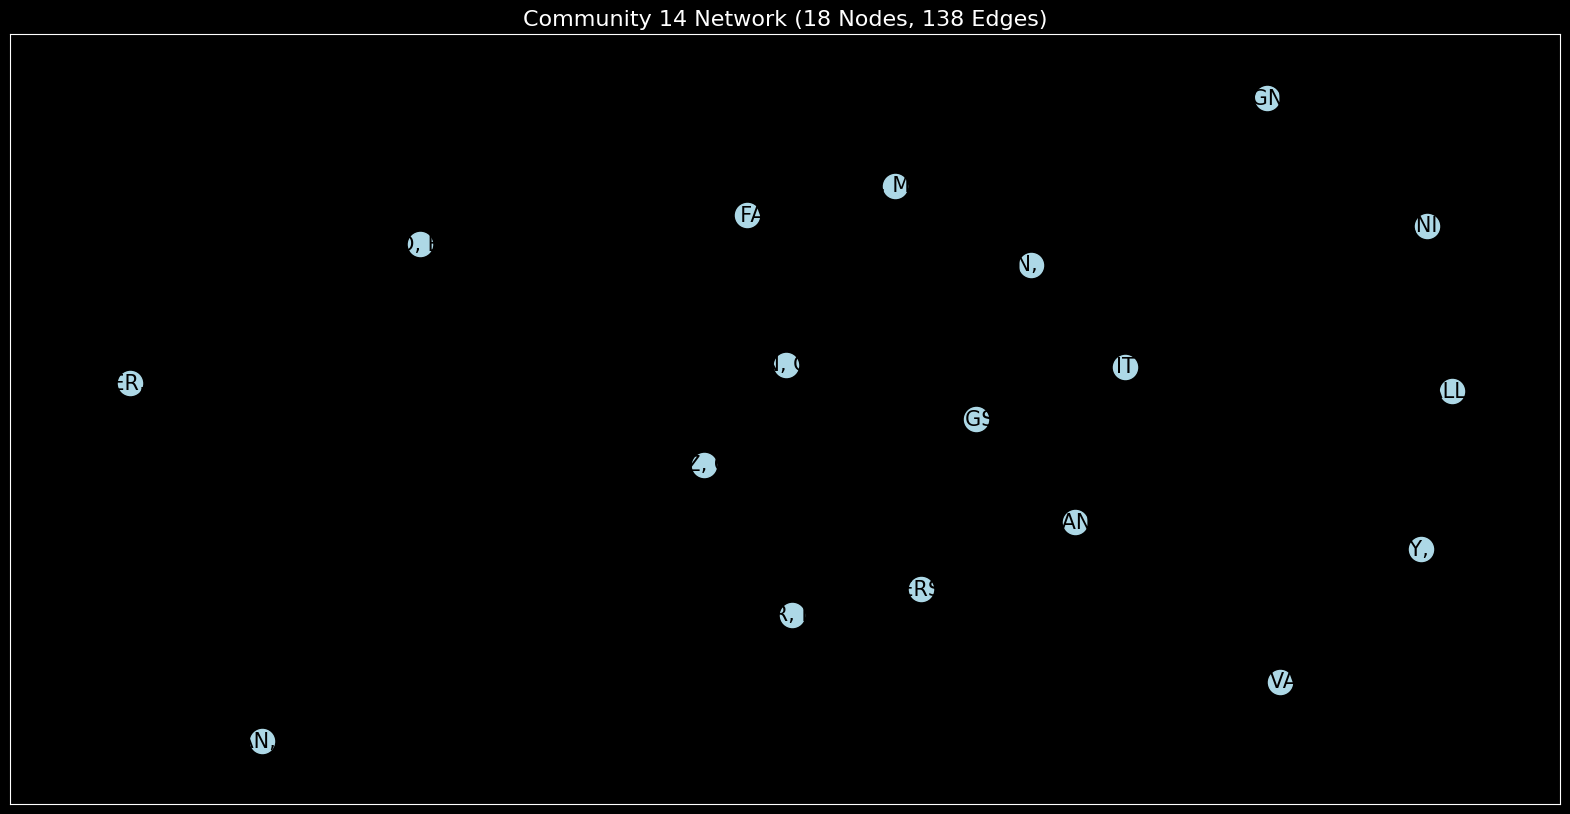

Top 10 Kantengewichte der Helden in der Community 14:
O'BRYAN, BOB - IT: 20
O'BRYAN, BOB - CUMMINGS, DIANE: 20
IT - CUMMINGS, DIANE: 20
O'BRYAN, BOB - SIMON, FELIX: 19
IT - SIMON, FELIX: 19
CUMMINGS, DIANE - SIMON, FELIX: 19
KNUTZ, CINDY - PHIM, FATHER: 14
O'BRYAN, BOB - GREER, DAVID: 13
O'BRYAN, BOB - LOPEZ, MARIA II: 13
O'BRYAN, BOB - KNUTZ, CINDY: 13


In [298]:
plot_community(G_one_mode, communities, 13)

In diesem Netzwerk ist es interessant zu sehen, dass sehr viele Helden eine starke Verbindung miteinander haben. Nur wenige haben eine kleinere Kantengewichtung. Dies deutet darauf hin, dass die Helden in dieser Gemeinschaft in vielen verschiedenen Comics zusammen auftreten. Es gibt keine "Brücken"-Helden, die die Gemeinschaft mit anderen Helden verbinden. Dies ist ein Hinweis darauf, dass die Helden in dieser Gemeinschaft in vielen verschiedenen Comics zusammen auftreten.

##### Edge Betweenness

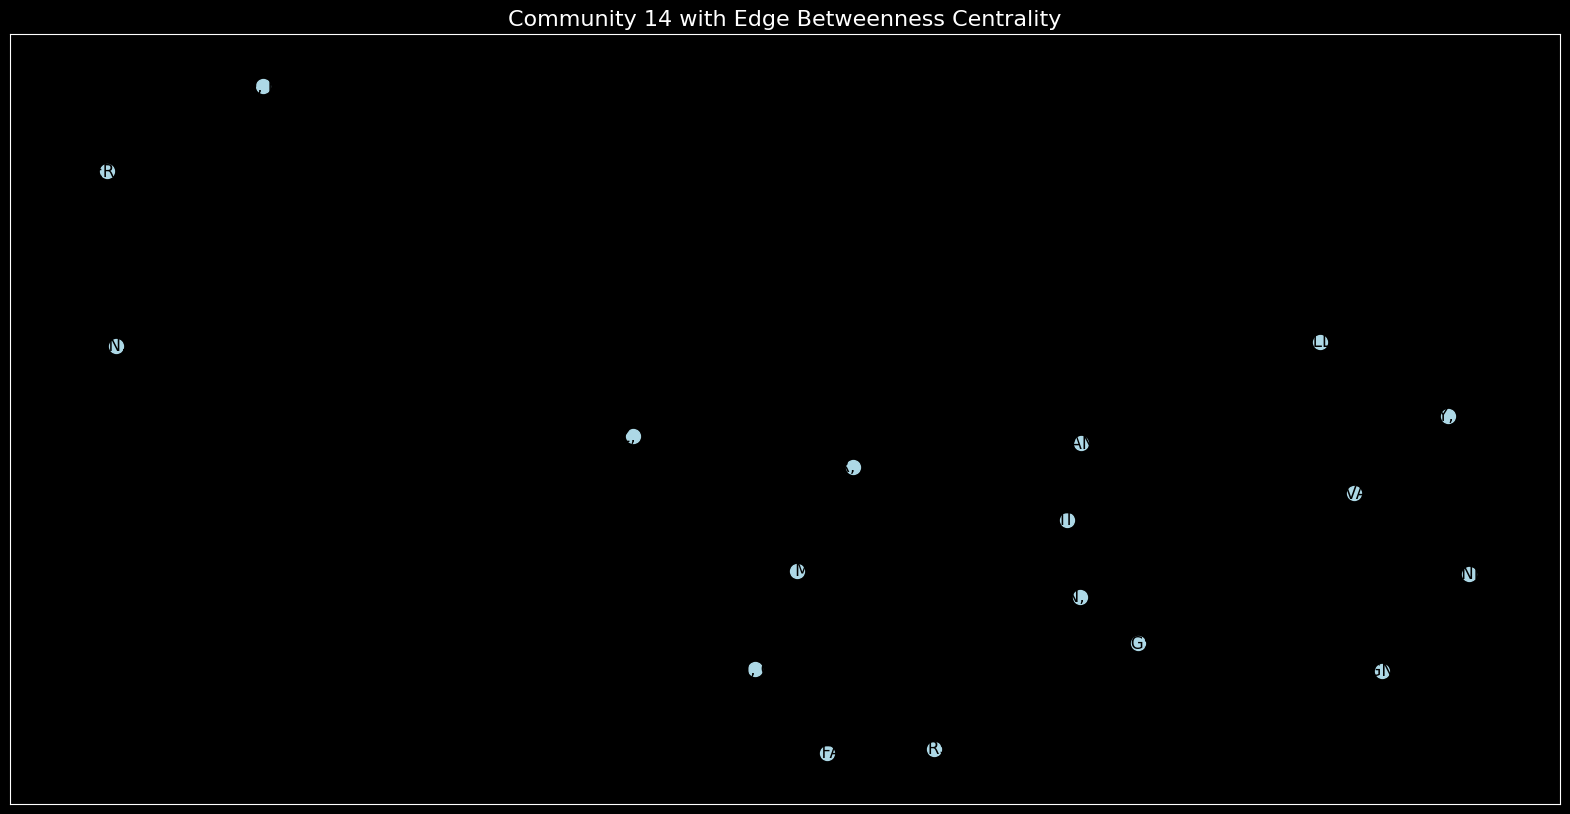

Top 10 Edges by Edge Betweenness Centrality in Community 14:
('BOSCO, ELAINE', 'KNUTZ, CINDY'): 0.0980
('LEFLER, BOB', 'KNUTZ, CINDY'): 0.0980
('KNUTZ, CINDY', 'COWAN, EARL'): 0.0980
("O'BRYAN, BOB", 'KNUTZ, CINDY'): 0.0588
('KNUTZ, CINDY', 'CUMMINGS, DIANE'): 0.0588
('KNUTZ, CINDY', 'IT'): 0.0588
('KNUTZ, CINDY', 'SIMON, FELIX'): 0.0588
('GREER, DAVID', 'KNUTZ, CINDY'): 0.0261
('LOPEZ, MARIA II', 'KNUTZ, CINDY'): 0.0261
('KNUTZ, CINDY', 'SANDERS, MAC'): 0.0261


In [299]:
plot_community_edge_betweenness(G_one_mode, communities, 13)

Bei diesem Netzwerk sind die Verbindungen ausgeglichener und es gibt nicht wirklich eine Kante, welche evrschiedene Gruppierungen des Geeinschafts zusammenhält. Ausser die Verbindungen zu 'KNUTZ, CINDY' sind etwas stärker.

### Top 100 Helden Netzwerk

Wir werden nun untersuchen, welche Gemeinschaften es bei den 100 am häufigsten vorkommenden Helden gibt.

#### Gemeinschaften

Gemeinschaft 1: ['ANGEL/WARREN KENNETH', 'ANT-MAN/DR. HENRY J.', 'BALDER [ASGARDIAN]', 'BANNER, BETTY ROSS T', "BLACK PANTHER/T'CHAL", 'CAGE, LUKE/CARL LUCA', 'CAPTAIN MARVEL II/MO', 'CLEA', 'CRYSTAL [INHUMAN]', 'CYCLOPS/SCOTT SUMMER'] ... [55 Helden]
Gemeinschaft 2: ['BANSHEE/SEAN CASSIDY', 'BEAST/HENRY &HANK& P', 'BINARY/CAROL DANVERS', 'BLACK KNIGHT V/DANE', 'BLACK WIDOW/NATASHA', 'BOOMER/TABITHA SMITH', 'CANNONBALL II/SAM GU', 'CAPTAIN AMERICA', 'CAPTAIN BRITAIN/BRIA', 'COLOSSUS II/PETER RA'] ... [45 Helden]

Total number of communities detected: 2


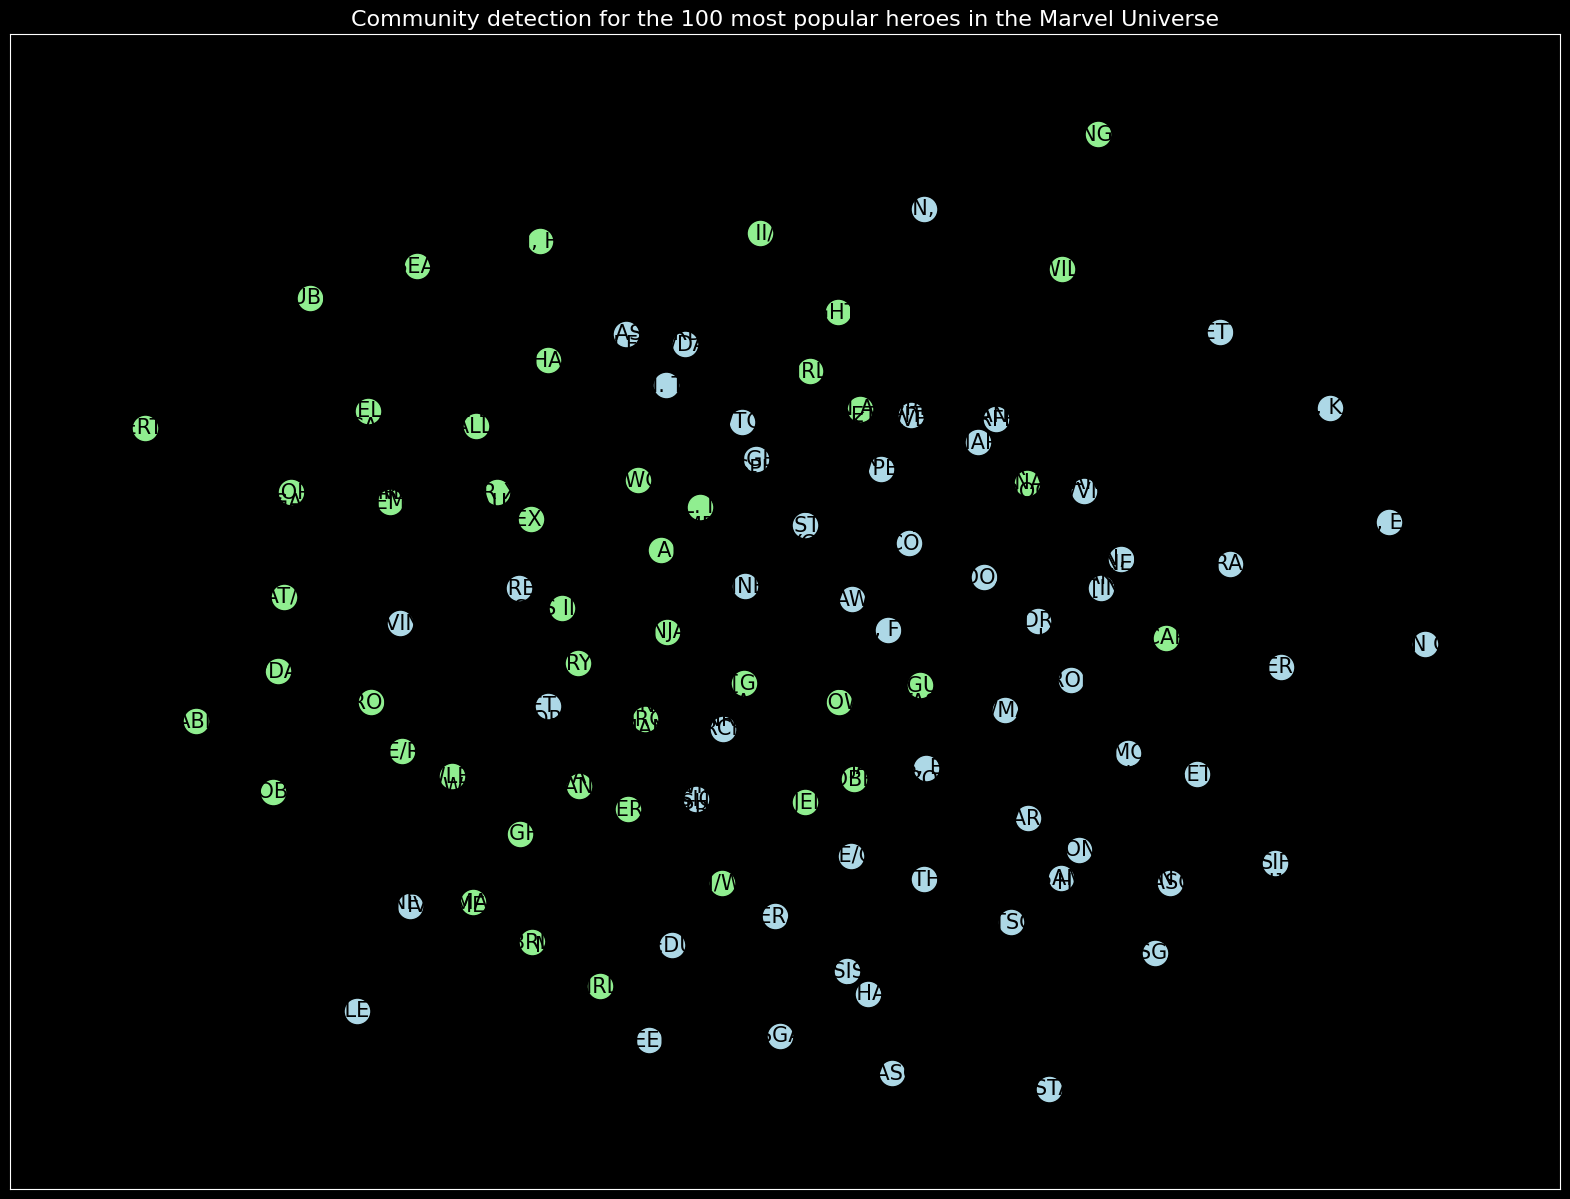

In [300]:
communities_top_100 = get_communities(top_heroes_subgraph, "Helden")

plt.figure(figsize=(20, 15))
plt.title("Community detection for the 100 most popular heroes in the Marvel Universe", fontsize=16)
draw_graph_and_color_groups(top_heroes_subgraph, communities_top_100, "spring")
plt.show()

Die Greedy Modularity Methode liefert bei dem Netzwerk mit den top 100 Helden 2 verschiedene Communities. Die Visualisierung zeigt eine hohe Dichte an Verbindungen zwischen den Helden, was die Zusammenarbeit und Interaktionen innerhalb des Marvel-Universums widerspiegelt. Einige Helden scheinen zentrale Knotenpunkte in ihren Gemeinschaften zu sein, mit vielen Verbindungen zu anderen Helden derselben Community.

#### Community 1

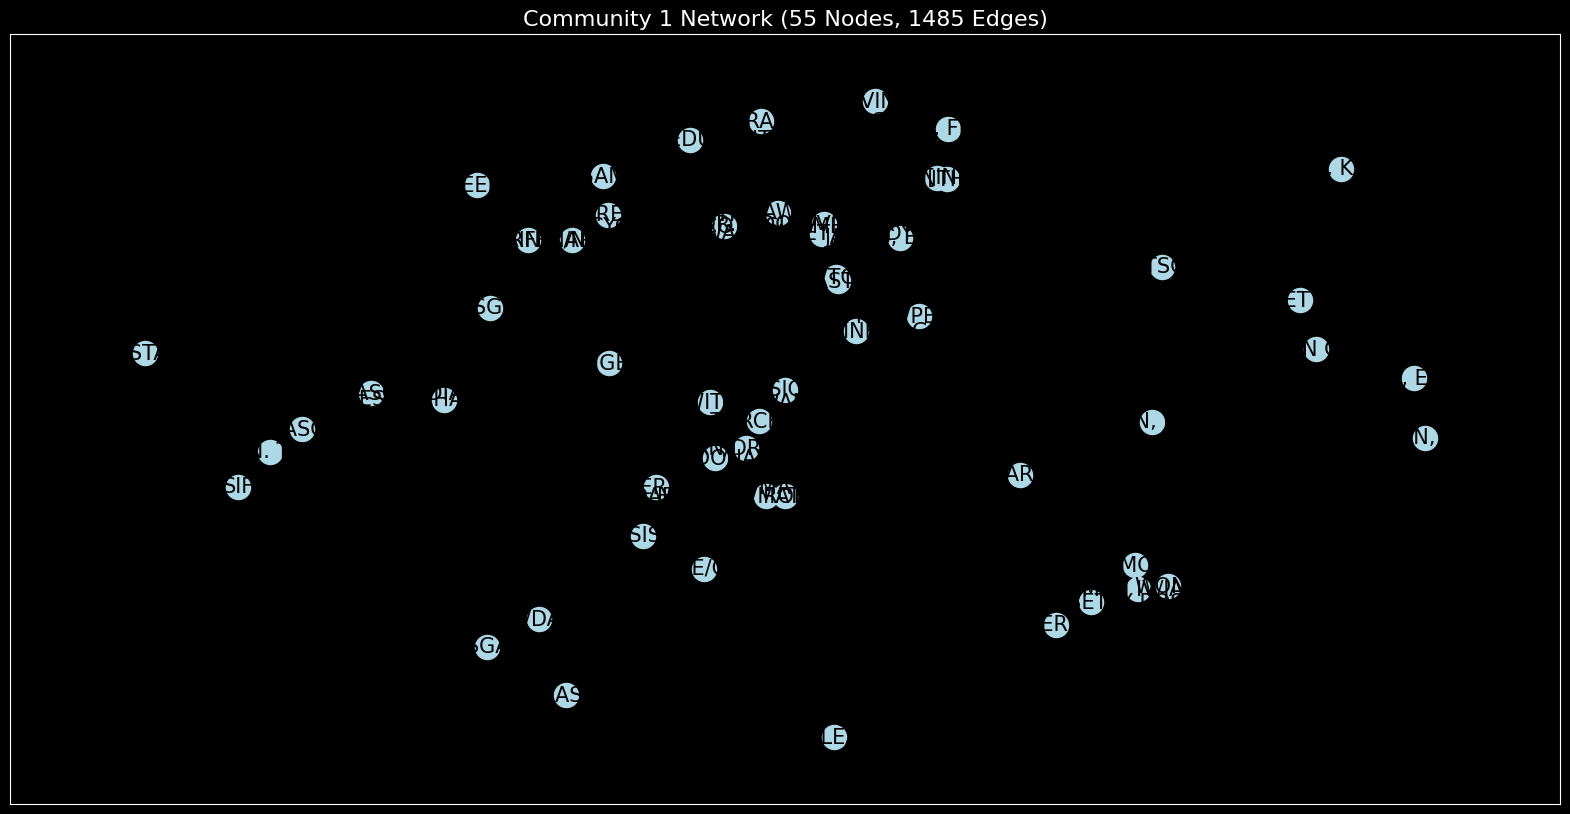

Top 10 Kantengewichte der Helden in der Community 1:
MR. FANTASTIC/REED R - HUMAN TORCH/JOHNNY S: 1177
SCARLET WITCH/WANDA - IRON MAN/TONY STARK: 1079
SCARLET WITCH/WANDA - VISION: 1038
VISION - IRON MAN/TONY STARK: 958
THOR/DR. DONALD BLAK - IRON MAN/TONY STARK: 919
HAWK - IRON MAN/TONY STARK: 916
ANGEL/WARREN KENNETH - CYCLOPS/SCOTT SUMMER: 914
WOLVERINE/LOGAN - CYCLOPS/SCOTT SUMMER: 901
WASP/JANET VAN DYNE - IRON MAN/TONY STARK: 894
SCARLET WITCH/WANDA - HAWK: 885


In [301]:
plot_community(G_one_mode, communities_top_100, 0)

#### Community 2

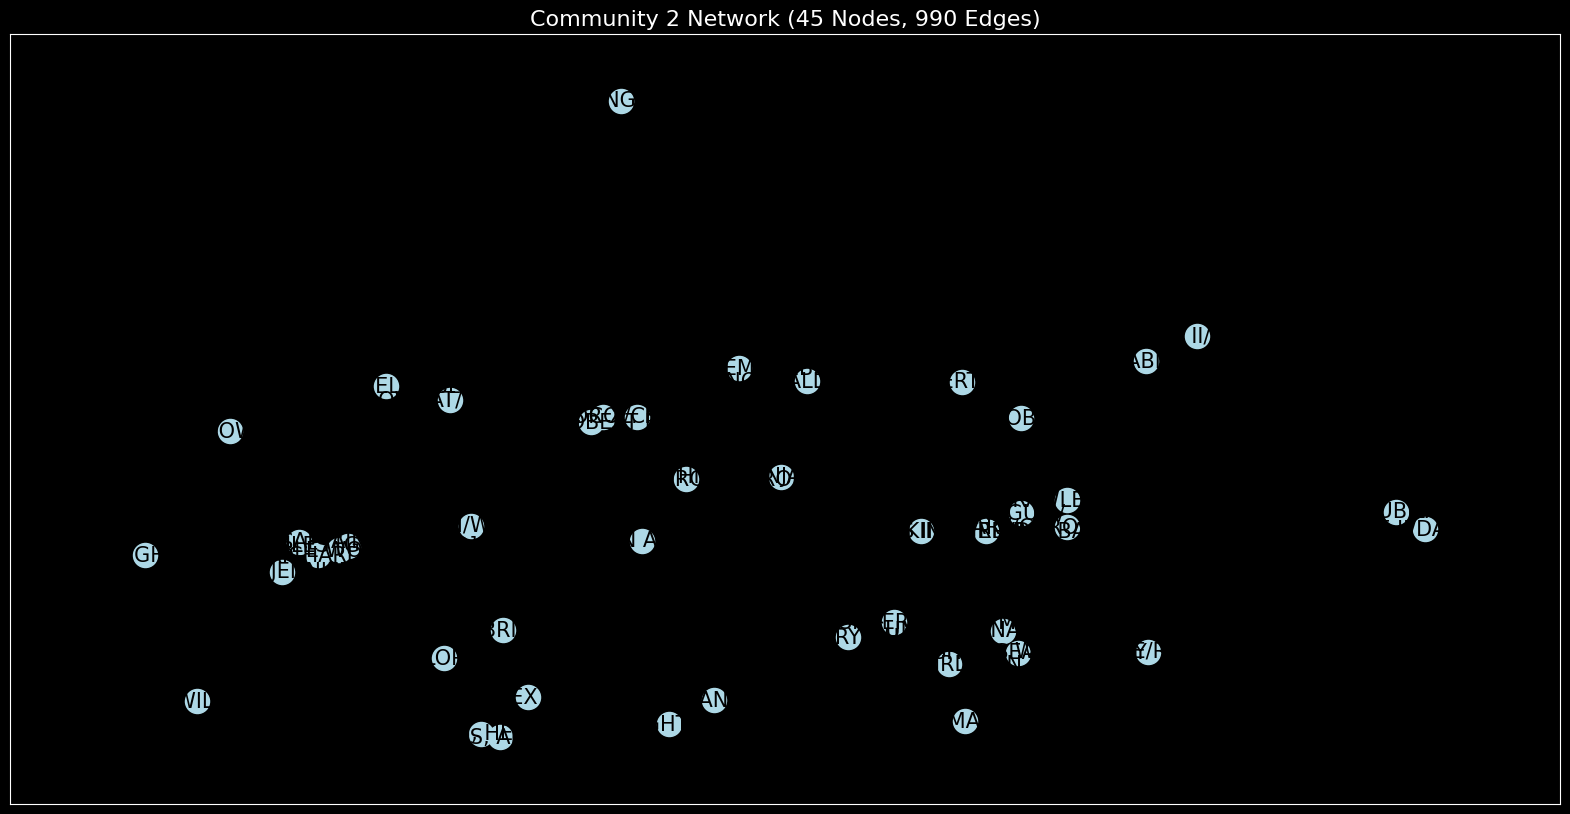

Top 10 Kantengewichte der Helden in der Community 2:
INVISIBLE WOMAN/SUE - THING/BENJAMIN J. GR: 1176
THING/BENJAMIN J. GR - CAPTAIN AMERICA: 969
COLOSSUS II/PETER RA - STORM/ORORO MUNROE S: 910
SHE-HULK/JENNIFER WA - CAPTAIN AMERICA: 883
INVISIBLE WOMAN/SUE - CAPTAIN AMERICA: 882
BEAST/HENRY &HANK& P - ICEMAN/ROBERT BOBBY: 879
WONDER MAN/SIMON WIL - CAPTAIN AMERICA: 873
BEAST/HENRY &HANK& P - MARVEL GIRL/JEAN GRE: 868
BEAST/HENRY &HANK& P - CAPTAIN AMERICA: 858
HERCULES [GREEK GOD] - CAPTAIN AMERICA: 838


In [302]:
plot_community(G_one_mode, communities_top_100, 1)

Beim ganzen Netzwerk haben wir bei einigen Communities die Edge-Betweenness-Zentralität berechnet. Hier ist dies nicht nötig, da die Communities so stark vernetzt sind. Die Edge-Betweenness-Zentralität wären bei allen Kanten ungefähr gleich und ist daher für die Analyse nicht förderlich.

### Was haben wir von der Community-Detection gelernt?

- Existenz von Gemeinschaften: Wir haben festgestellt, dass es klar definierte Gruppen oder Gemeinschaften von Helden gibt, die häufig zusammen in Comics erscheinen. Diese Gemeinschaften können Teams, Allianzen oder andere Gruppierungen von Charakteren repräsentieren, die in der Erzählwelt gemeinsame Ziele oder Feinde haben.

- Schlüsselcharaktere: Innerhalb der identifizierten Gemeinschaften haben wir durch die Berechnung der Edge Betweenness Centrality wichtige Charaktere identifiziert, die als zentrale Verbindungspunkte dienen. Diese Charaktere spielen oft eine entscheidende Rolle in der Erzählung, da sie verschiedene Handlungsstränge zusammenführen oder als wichtige Mitglieder ihrer Gruppen fungieren.

- Netzwerkdichte: Die Visualisierung des Netzwerks hat gezeigt, dass einige Gemeinschaften eine sehr dichte Vernetzung aufweisen, was auf enge Beziehungen und regelmässige Interaktionen zwischen den Mitgliedern hinweist.

- Randfiguren: Ebenso konnten wir beobachten, dass es Charaktere gibt, die weniger zentral sind und am Rand der Gemeinschaften stehen. Diese könnten Nebencharaktere sein, die weniger Einfluss auf die Haupterzählung haben.

## Frage 4 - Identifizierung von Helden mit einem Grad von 1

Diese Frage geht auf unsere Erkenntnisse in der Explorativen Datenanalyse zurück. Wir haben festgestellt, dass es Helden gibt, die nur in einem einzigen Comic auftreten.

In [303]:
# Calculate degree
degrees = {hero: B.degree(hero) for hero in B.nodes()}

# Filter out the heroes with only one comic
heroes_with_one_comic = [hero for hero, deg in degrees.items() if deg == 1]

print("Anzahl Helden im gesamten Datensatz, welche nur in einem einzigen Comic erscheinen:", len(heroes_with_one_comic))
print(heroes_with_one_comic[:5])

Anzahl Helden im gesamten Datensatz, welche nur in einem einzigen Comic erscheinen: 3275
['24-HOUR MAN/EMMANUEL', 'ABBOTT, JACK', 'ABOMINATION | MUTANT', 'ABSORBING MAN | MUTA', 'ACBA']


In [304]:
# Filtern nach Helden mit dem höchsten Grad
top_degree_hero, degree = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[0]
print(top_degree_hero + " hat den höchsten Grad mit " + str(degree) + " Comics.")

SPIDER-MAN/PETER PARKER hat den höchsten Grad mit 1577 Comics.


## Frage 5 - Gibt es Gruppen von Comics?

comics als nodes und zentralitäten und so berechnen, communities etc

In [305]:
# get top 200 comics with the most heroes
edges_df_subset_top_100 = edges_df.groupby('comic').count().sort_values(by='hero', ascending=False).head(200).reset_index()
comics_nodes = edges_df_subset_top_100.comic.tolist()

# create a subset of edges_df with only the top 200 comics
edges_df_subset = edges_df.comic.isin(comics_nodes)
edges_df_subset = edges_df[edges_df_subset]

Um communities mit Networkx zu finden, sollte man keine bipartiten Netzwerke verwenden. Deshalb haben wir uns entschieden, die Comics als nodes zu nehmen und die Helden als edges.
Danach testen wir verschiedene algorithmen und schauen, vergleichen diese und schauen welche die besten Ergebnisse liefern.

In [306]:
G_uni = nx.Graph()

G_uni.add_nodes_from(comics_nodes, bipartite=0)

hero_to_comics = edges_df_subset.groupby('hero')['comic'].apply(set).to_dict()
# Iterate through each hero and their corresponding set of comics
for hero, comics in hero_to_comics.items():
    # Create edges between all pairs of comics that this hero appears in
    for comic1, comic2 in combinations(comics, 2):
        # If an edge already exists (another hero connects these comics), increment the weight
        if G_uni.has_edge(comic1, comic2):
            G_uni[comic1][comic2]['weight'] += 1
        else:
            # Otherwise, create a new edge with weight 1
            G_uni.add_edge(comic1, comic2, weight=1)

# Vergleich von Community-Detection-Algorithmen in NetworkX

## Greedy Modularity Communities

- **Erklärung**: Dieser Algorithmus optimiert gierig die Modularität eines Netzwerks. Die Modularität misst die Dichte der Kanten innerhalb von Communities im Vergleich zu Kanten zwischen Communities. Eine höhere Modularität bedeutet eine stärkere Aufteilung des Netzwerks in Communities.
- **Am besten für**: Große Netzwerke, in denen die Modularität effizient berechnet werden kann. Funktioniert gut, wenn Communities intern dicht verbunden sind.
- **Einschränkungen**: Kann kleinere Communities innerhalb größerer nicht immer erkennen. Der gierige Ansatz findet möglicherweise nicht immer die optimale Modularität.

## Girvan-Newman Algorithmus

- **Erklärung**: Dieser Algorithmus basiert auf der Kanten-Zwischenzentralität. Er entfernt iterativ die Kanten mit der höchsten Zwischenzentralität - ein Maß für die Wichtigkeit einer Kante, basierend auf der Anzahl der kürzesten Pfade, die durch sie verlaufen. Durch das Entfernen dieser Kanten zerfällt das Netzwerk in Communities.
- **Am besten für**: Netzwerke, in denen die Community-Struktur durch Informationsflaschenhälse definiert wird, da er die "Brücken" zwischen Communities anvisiert.
- **Einschränkungen**: Rechenintensiv, besonders für große Netzwerke, da die Zwischenzentralität nach jedem Kantenentfernen neu berechnet wird.

## Label Propagation

- **Erklärung**: Dieser Algorithmus funktioniert, indem er Labels im Netzwerk verbreitet und Communities auf Basis dieses Labeling-Prozesses bildet. Jeder Knoten übernimmt das Label, das die meisten seiner Nachbarn derzeit haben. Dieser iterative Prozess konvergiert zu einem Zustand, in dem die Labels lokal konsistent sind.
- **Am besten für**: Große Netzwerke, in denen eine schnelle Ausführung erforderlich ist, und die Community-Struktur nicht stark ausgeprägt ist.
- **Einschränkungen**: Ergebnisse können zwischen Durchläufen inkonsistent sein, da sie zu verschiedenen Lösungen konvergieren können, und funktioniert möglicherweise nicht gut bei überlappenden Communities.

## Vergleich

- **Geschwindigkeit**: Label Propagation ist im Allgemeinen schneller und skalierbarer für große Netzwerke als der Girvan-Newman, der rechenintensiv ist.
- **Determinismus**: Außer bei Label Propagation, das bei verschiedenen Durchläufen unterschiedliche Ergebnisse liefern kann, sind die anderen Algorithmen deterministisch.
- **Community-Überlappung**: Die meisten Algorithmen gehen davon aus, dass Communities disjunkt sind.


In [307]:
communities_greedy_modularity = community.greedy_modularity_communities(G_uni)

# Print the detected communities
for i, comm in enumerate(communities_greedy_modularity, start=1):
    print(f"Community {i}: {sorted(comm)}")


Community 1: ["A '99", 'A 1', 'A 118', 'A 12', 'A 15', 'A 16', 'A 18', 'A 188', 'A 19', 'A 305', 'A 329', 'A 332', 'A 333', 'A 345', 'A 60', 'A3 1', 'A3 10', 'A3 11', 'A3 2', 'A3 3', 'A3 32', 'A3 4', 'A3 43', 'A:T', 'AR 1', 'AR 2', 'ASM 1', 'ASM 18', 'ASM2 1', 'AWC 82', 'CA 319', 'CA 342', 'CA 389', 'CA 390', 'CA 391', 'CA 401', 'COC 1', 'DAZZ 21', 'DD2 8', 'DEF 113', 'DEF 63', 'E2 12', 'FF 14', 'FF 22', 'FF 23', 'FF 25', 'FF 3', 'FF 416', 'FF3 27', 'FF3 6', 'H2 277', 'H2 278', 'H2 279', 'HFH 16', 'HFH 8', 'HR:R 4', 'IG 2', 'IG 3', 'IG 4', 'IG 5', 'IG 6', "IM '99", 'M/:LG 12', 'M/GN 1', 'M/SHSW 1', 'M/SHSW 10', 'M/SHSW 11', 'M/SHSW 12', 'M/SHSW 2', 'M/SHSW 3', 'M/SHSW 4', 'M/SHSW 5', 'M/SHSW 6', 'M/SHSW 7', 'M/SHSW 8', 'M/SHSW 9', 'M/TIO 7', 'M/TIO 96', 'MARVELS 2', 'MAXSEC 1', 'MAXSEC 2', 'MAXSEC 3', 'NW 1', 'O:MU', 'Q 14', 'Q 23', 'Q 25', 'Q 33', 'QS 12', 'S-M 23', 'ST 156', 'SWII 5', 'SWII 9', 'T 291', 'T 300', 'T 301', 'T 427', 'TB 24', 'TB 25', 'TB 32', 'TB 44', 'TB 49', 'TB 6', '

In [308]:
communities_girvan_newman = next(community.girvan_newman(G_uni))

# Print the detected communities
for i, comm in enumerate(communities_girvan_newman, start=1):
    print(f"Community {i}: {sorted(comm)}")


Community 1: ["A '99", 'A 1', 'A 10', 'A 118', 'A 12', 'A 15', 'A 16', 'A 18', 'A 188', 'A 19', 'A 305', 'A 329', 'A 332', 'A 333', 'A 345', 'A 60', 'A3 1', 'A3 10', 'A3 11', 'A3 2', 'A3 3', 'A3 32', 'A3 4', 'A3 43', 'A:T', 'AF 110', 'AF 111', 'AF 61', 'AF2 12', 'AR 1', 'AR 2', 'ASM 1', 'ASM 18', 'ASM2 1', 'AWC 82', 'CA 319', 'CA 342', 'CA 389', 'CA 390', 'CA 391', 'CA 401', 'COC 1', 'COC 3', 'DAMCON3 4', 'DAZZ 21', 'DD2 8', 'DEF 113', 'DEF 62', 'DEF 63', 'DEF 64', 'E2 12', 'FF 14', 'FF 22', 'FF 23', 'FF 25', 'FF 3', 'FF 367', 'FF 368', 'FF 369', 'FF 370', 'FF 416', 'FF3 27', 'FF3 6', 'H2 277', 'H2 278', 'H2 279', 'HFH 16', 'HFH 8', 'HR:R 4', 'IG 2', 'IG 3', 'IG 4', 'IG 5', 'IG 6', "IM '99", 'IM3 1', 'INH3 4', 'IW 1', 'IW 2', 'IW 3', 'IW 4', 'IW 5', 'IW 6', 'M/:LG 12', 'M/GN 1', 'M/SHSW 1', 'M/SHSW 10', 'M/SHSW 11', 'M/SHSW 12', 'M/SHSW 2', 'M/SHSW 3', 'M/SHSW 4', 'M/SHSW 5', 'M/SHSW 6', 'M/SHSW 7', 'M/SHSW 8', 'M/SHSW 9', 'M/TIO 7', 'M/TIO 96', 'M:DS 2', 'MARVELS 2', 'MAXSEC 1', 'MAXS

In [309]:
# Assuming 'G' is your unipartite graph
communities_label_propagation = list(community.label_propagation_communities(G_uni))

# Print the detected communities
for i, comm in enumerate(communities_label_propagation, start=1):
    print(f"Community {i}: {sorted(comm)}")


Community 1: ["A '99", 'A 1', 'A 10', 'A 118', 'A 12', 'A 15', 'A 16', 'A 18', 'A 188', 'A 19', 'A 305', 'A 329', 'A 332', 'A 333', 'A 345', 'A 60', 'A3 1', 'A3 10', 'A3 11', 'A3 2', 'A3 3', 'A3 32', 'A3 4', 'A3 43', 'A:T', 'AF 110', 'AF 111', 'AF 61', 'AF2 12', 'AR 1', 'AR 2', 'ASM 1', 'ASM 18', 'ASM2 1', 'AWC 82', 'CA 319', 'CA 342', 'CA 389', 'CA 390', 'CA 391', 'CA 401', 'COC 1', 'COC 3', 'DAMCON3 4', 'DAZZ 21', 'DD2 8', 'DEF 113', 'DEF 62', 'DEF 63', 'DEF 64', 'E2 12', 'FF 14', 'FF 22', 'FF 23', 'FF 25', 'FF 3', 'FF 367', 'FF 368', 'FF 369', 'FF 370', 'FF 416', 'FF3 27', 'FF3 6', 'H2 277', 'H2 278', 'H2 279', 'HFH 16', 'HFH 8', 'HR:R 4', 'IG 2', 'IG 3', 'IG 4', 'IG 5', 'IG 6', "IM '99", 'IM3 1', 'INH3 4', 'IW 1', 'IW 2', 'IW 3', 'IW 4', 'IW 5', 'IW 6', 'M/:LG 12', 'M/GN 1', 'M/SHSW 1', 'M/SHSW 10', 'M/SHSW 11', 'M/SHSW 12', 'M/SHSW 2', 'M/SHSW 3', 'M/SHSW 4', 'M/SHSW 5', 'M/SHSW 6', 'M/SHSW 7', 'M/SHSW 8', 'M/SHSW 9', 'M/TIO 7', 'M/TIO 96', 'M:DS 2', 'MARVELS 2', 'MAXSEC 1', 'MAXS

# Analyse der Unterschiede zwischen den Algorithmen

### Sicherstellen, dass bei jedem Algorithmus alle Comics enthalten sind (200)

In [310]:
amount = 0
for i in range(0, len(communities_label_propagation)):
    amount += len(communities_label_propagation[i])
print(f"Amount of comics in communities louvain: {amount}")

amount = 0
for i in range(0, len(communities_greedy_modularity)):
    amount += len(communities_greedy_modularity[i])
print(f"Amount of comics in communities greedy modularity: {amount}")

amount = 0
for i in range(0, len(communities_girvan_newman)):
    amount += len(communities_girvan_newman[i])
print(f"Amount of comics in communities girvan newman: {amount}")


Amount of comics in communities louvain: 200
Amount of comics in communities greedy modularity: 200
Amount of comics in communities girvan newman: 200


Alle Algorithmen beinhalten in den communities alle 200 Comics.

### Anzahl der Comunities

In [311]:
# ensure all communities include all comics
#print(f"Anzahl der Cominities in fluid: {len(communities_fluid)}")
print(f"Anzahl der Cominities in greedy modularity: {len(communities_greedy_modularity)}")
print(f"Anzahl der Cominities in grivan newman: {len(communities_girvan_newman)}")
print(f"Anzahl der Cominities in label propagation: {len(communities_label_propagation)}")

Anzahl der Cominities in greedy modularity: 2
Anzahl der Cominities in grivan newman: 2
Anzahl der Cominities in label propagation: 1


In [312]:
# Calculate modularity
modularity_1 = community.modularity(G_uni, communities_greedy_modularity)
modularity_2 = community.modularity(G_uni, communities_girvan_newman)
modularity_3 = community.modularity(G_uni, communities_label_propagation)

print(f"Modularity for greedy modularity: {modularity_1}")
print(f"Modularity for girvan newman: {modularity_2}")
print(f"Modularity for label propagation: {modularity_3}")


Modularity for greedy modularity: 0.13682282426809697
Modularity for girvan newman: -2.921265607599702e-07
Modularity for label propagation: 0.0


### Schlussfolgerungen zur Modularity

Die Modularitätswerte für die verschiedenen Community-Detection-Algorithmen (Greedy Modularity, Girvan-Newman und Label Propagation) liefern wichtige Einblicke in die Effektivität dieser Methoden bei der Identifizierung klar strukturierter Gemeinschaften innerhalb des Netzwerks. Hier sind die detaillierten Schlussfolgerungen:

#### Greedy Modularity

- **Modularität**: 0.13682282426809697
- **Interpretation**: Dieser positive Wert zeigt an, dass der Algorithmus funktionierende Communities identifizieren konnte. Obwohl die Communities nicht extrem dicht vernetzt sind, gibt es eine erkennbare Struktur, die sich von einer zufälligen Verteilung unterscheidet.

#### Girvan-Newman

- **Modularität**: -2.921265607599702e-07 (nahe Null)
- **Interpretation**: Dieser sehr niedrige, fast null nahe Wert weist darauf hin, dass die durch den Girvan-Newman-Algorithmus identifizierten Communities kaum strukturiert sind. Sie unterscheiden sich kaum von einer zufälligen Verteilung, was darauf hindeutet, dass dieser Algorithmus für die spezifische Struktur Ihres Netzwerks nicht geeignet sein könnte.

#### Label Propagation

- **Modularität**: 0.0
- **Interpretation**: Ein Wert von 0 bedeutet, dass die durch Label Propagation identifizierten Communities nicht strukturierter sind als zufällige Gruppierungen. Der Algorithmus konnte in diesem Fall keine bedeutungsvollen Gemeinschaften erkennen.

#### Gesamteinschätzung

Basierend auf den Modularitätswerten scheint der Greedy Modularity-Algorithmus am besten geeignet zu sein, um strukturierte Communities in Ihrem Netzwerk zu identifizieren. Sowohl Girvan-Newman als auch Label Propagation zeigen in diesem spezifischen Kontext geringere Effektivität. Es ist wichtig zu beachten, dass die Wirksamkeit von Community-Detection-Algorithmen stark von der Struktur des jeweiligen Netzwerks abhängt. Verschiedene Netzwerke können auf die gleichen Algorithmen unterschiedlich reagieren.


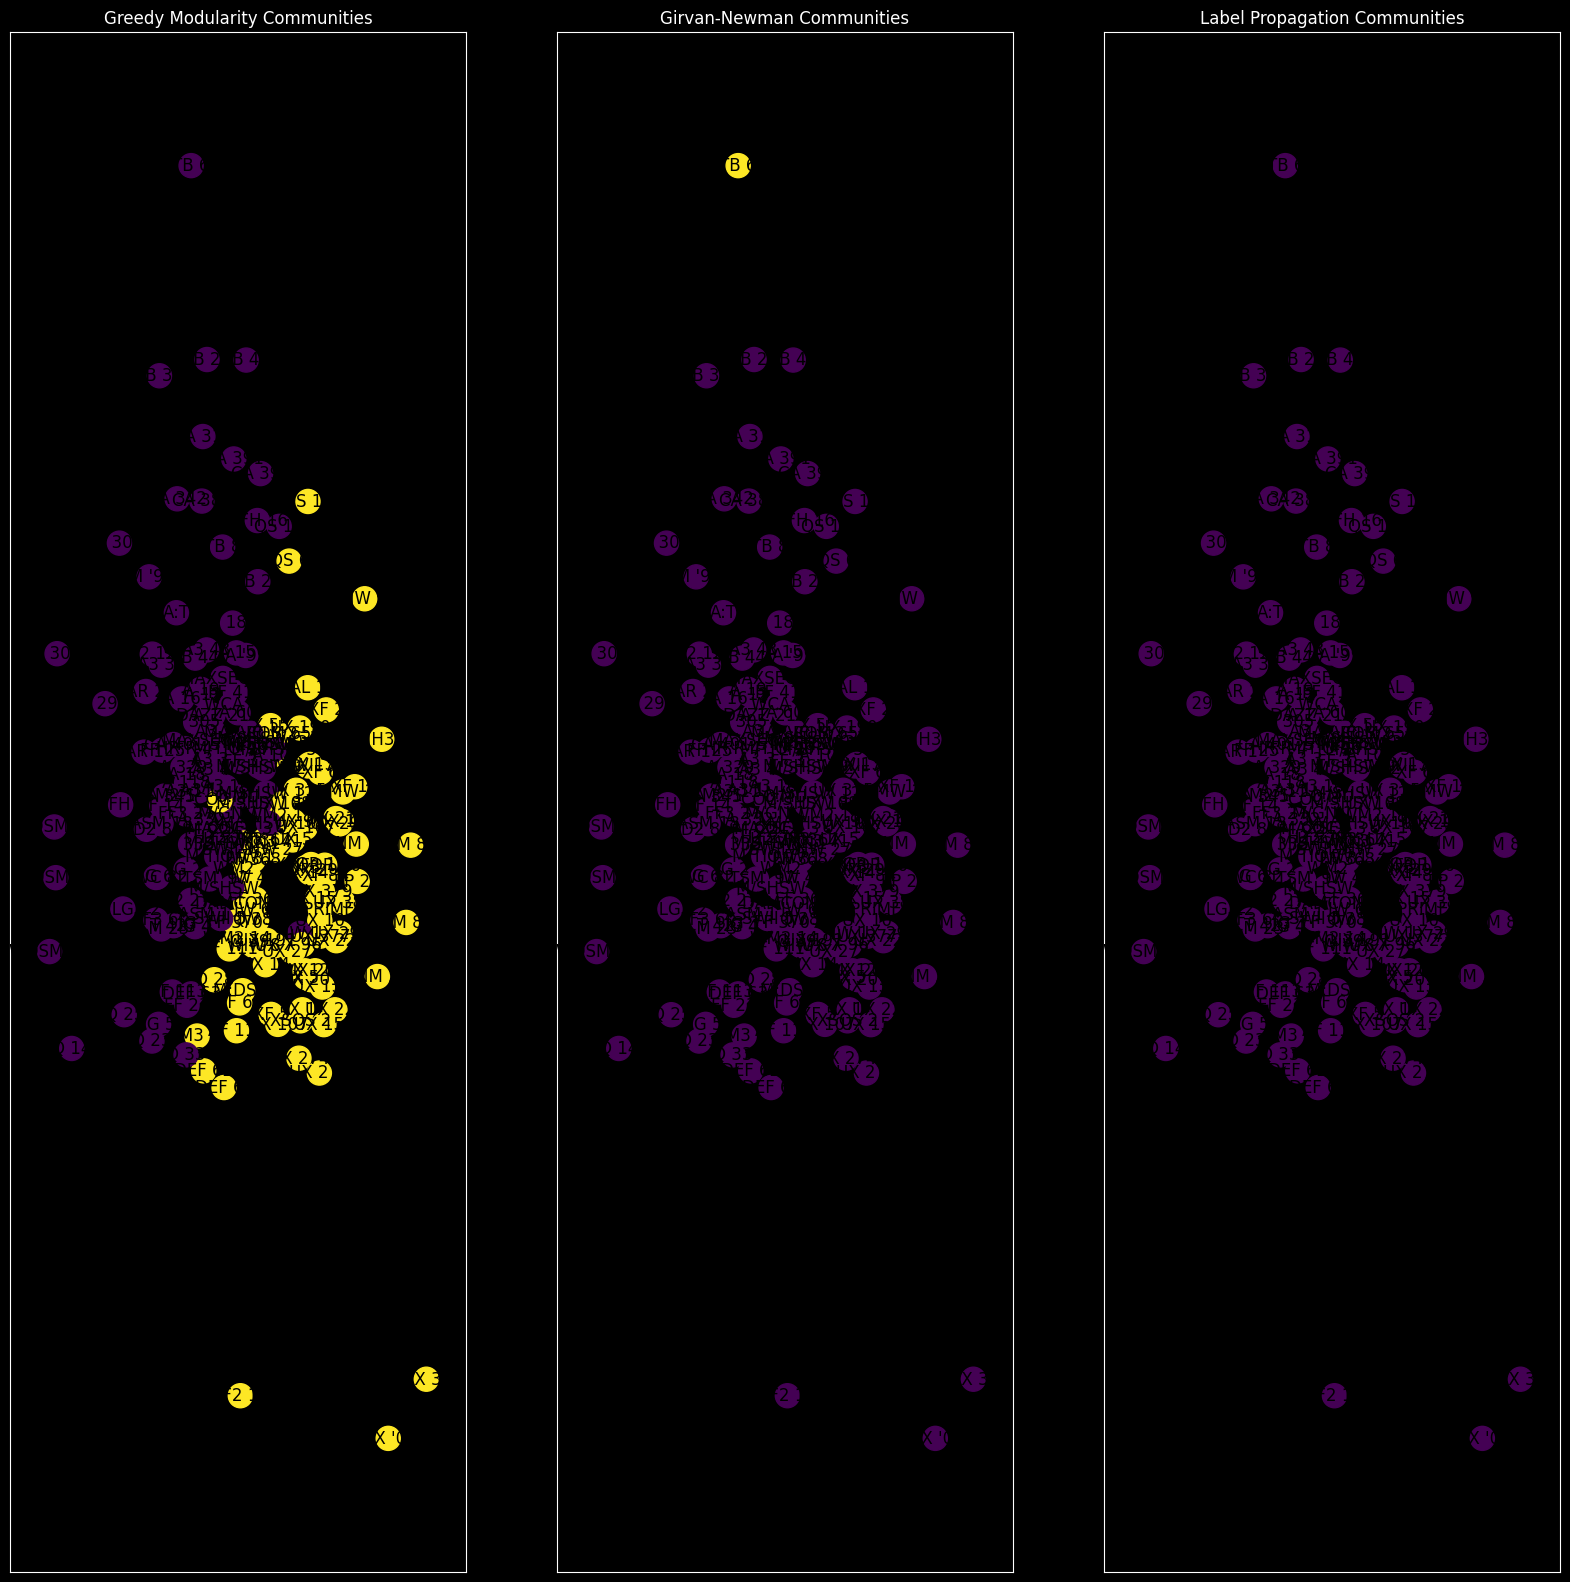

In [313]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming 'communities_greedy_modularity' is a list of sets, where each set is a community
# Convert the community structure to a dictionary for easier access
community_dict_greedy = {node: idx for idx, community in enumerate(communities_greedy_modularity) for node in community}
community_dict_girvan = {node: idx for idx, community in enumerate(communities_girvan_newman) for node in community}
community_dict_label = {node: idx for idx, community in enumerate(communities_label_propagation) for node in community}

# Define a coloring function
def coloring_function(community_dict, node):
    return community_dict.get(node, 0)  # Default color if the node is not in any community



# Assuming 'G_uni' is your graph
pos = nx.spring_layout(G_uni)
colors_greedy = [coloring_function(community_dict_greedy, node) for node in G_uni.nodes()]
colors_girvan = [coloring_function(community_dict_girvan, node) for node in G_uni.nodes()]
colors_label = [coloring_function(community_dict_label, node) for node in G_uni.nodes()]


# Create a subplot for each set of community colors
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))

# Greedy Modularity Communities Plot
ax1 = axes[0]
nx.draw_networkx(G_uni, pos, node_color=colors_greedy, ax=ax1)
ax1.set_title('Greedy Modularity Communities')

# Girvan-Newman Algorithm Plot
ax2 = axes[1]
nx.draw_networkx(G_uni, pos, node_color=colors_girvan, ax=ax2)
ax2.set_title('Girvan-Newman Communities')

# Label Propagation Algorithm Plot
ax3 = axes[2]
nx.draw_networkx(G_uni, pos, node_color=colors_label, ax=ax3)
ax3.set_title('Label Propagation Communities')

plt.show()

In [314]:
community_sizes_greedy_modularity = [len(c) for c in communities_greedy_modularity]
print(f"Sizes of communities: {community_sizes_greedy_modularity}")

community_sizes_girvan_newman = [len(c) for c in communities_girvan_newman]
print(f"Sizes of communities: {community_sizes_girvan_newman}")

community_sizes_label_propagation = [len(c) for c in communities_label_propagation]
print(f"Sizes of communities: {community_sizes_label_propagation}")


Sizes of communities: [109, 91]
Sizes of communities: [199, 1]
Sizes of communities: [200]


## Frage 6 - Welchen Einfluss auf das Netzwerk haben die Helden, welche am meisten im vorkommen?

Wir wollen nun untersuchen, wie das Netzwerk aussieht, wenn wir die bekanntesten Helden entfernen. Hier nochmals die top 10 Helden sortiert nach Degree Centrality aus dem ganzen Netzwerk:

In [315]:
top_heroes_by_degree = [hero for hero, _ in sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:10]]
top_heroes_by_degree

['CAPTAIN AMERICA',
 'SPIDER-MAN/PETER PARKER',
 'IRON MAN/TONY STARK',
 'THING/BENJAMIN J. GR',
 'MR. FANTASTIC/REED R',
 'HUMAN TORCH/JOHNNY S',
 'WOLVERINE/LOGAN',
 'SCARLET WITCH/WANDA',
 'BEAST/HENRY &HANK& P',
 'THOR/DR. DONALD BLAK']

In [316]:
def calculate_metrics(G):
    """
    Calculate various graph metrics.
    """
    metrics = {
        'number_of_edges': G.number_of_edges(),
        'connected_components': nx.number_connected_components(G),
        'average_clustering_coefficient': nx.average_clustering(G),
        'network_density': nx.density(G)
    }
    return metrics

# DataFrame to store the metrics
metrics_df = pd.DataFrame(columns = [
    'Hero Removed', 
    'Number of Edges', 
    'Connected Components', 
    'Average Clustering Coefficient', 
    'Network Density'])

# For each hero in the top 10, remove the hero and calculate metrics
for hero in top_heroes_by_degree:
    G_temp = G_one_mode.copy()
    G_temp.remove_node(hero)
    updated_metrics = calculate_metrics(G_temp)
    metrics_df.loc[len(metrics_df)] = [
        hero, 
        updated_metrics['number_of_edges'], 
        updated_metrics['connected_components'], 
        updated_metrics['average_clustering_coefficient'], 
        updated_metrics['network_density']]

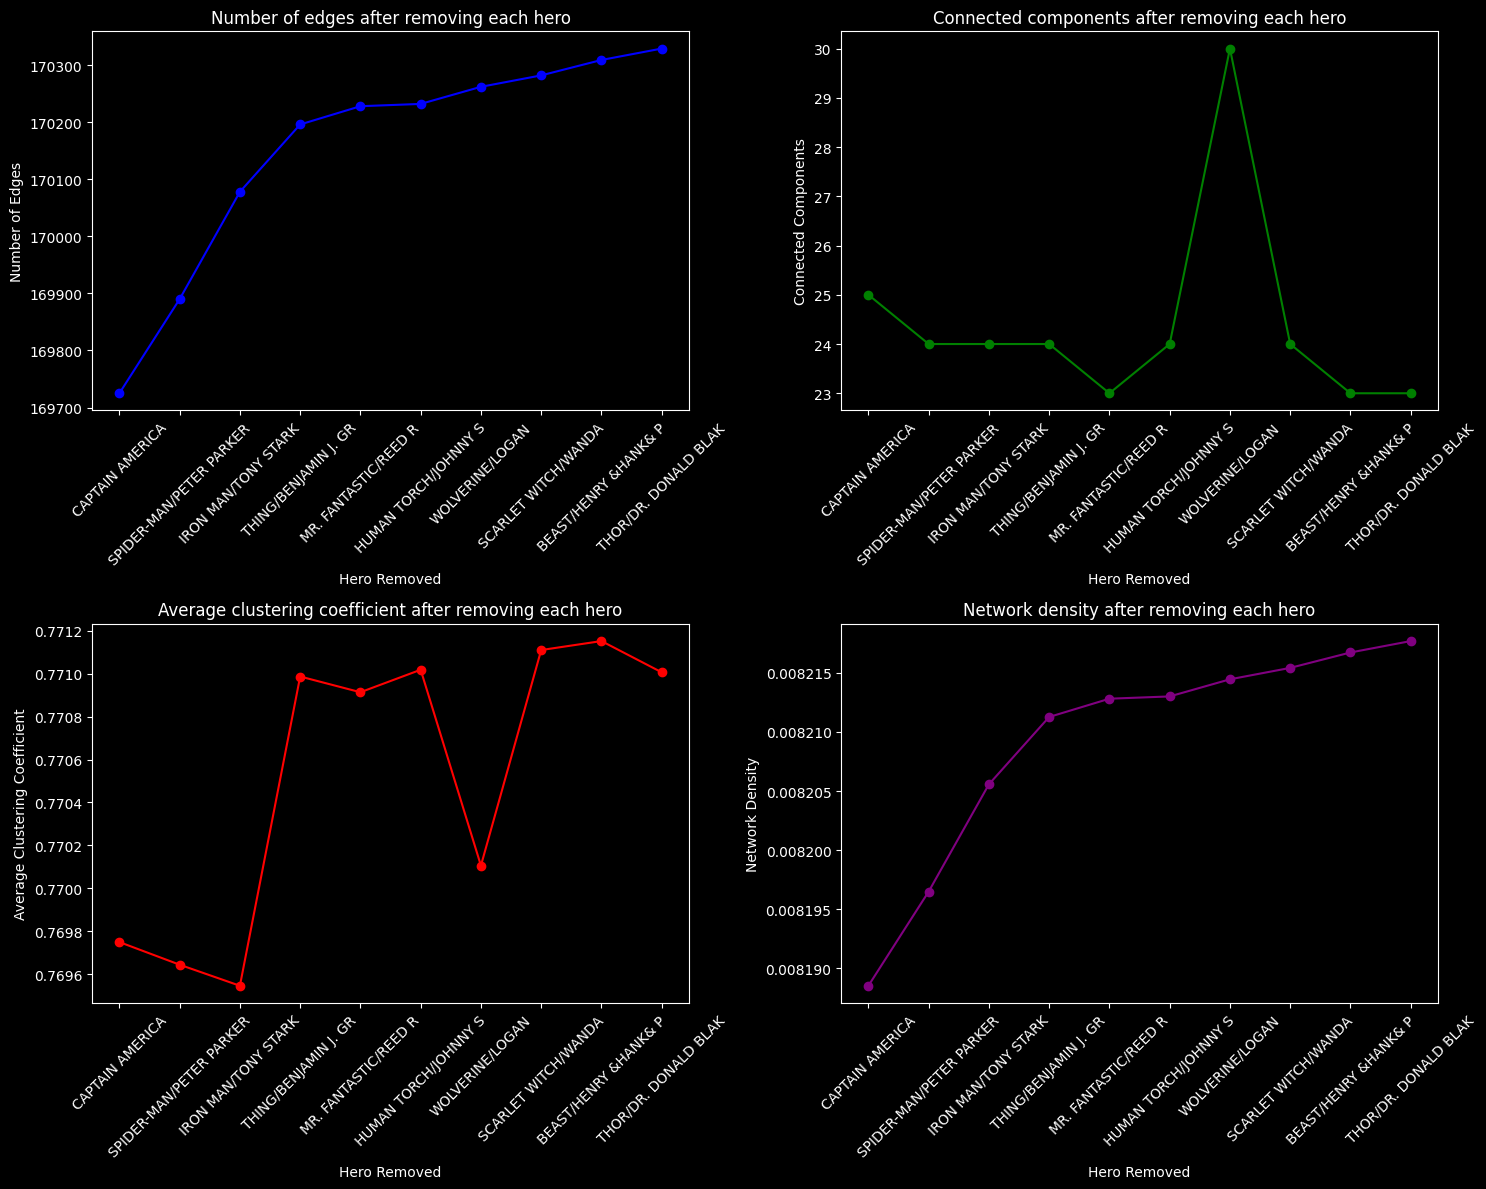

In [317]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plot for Number of Edges
axs[0, 0].plot(metrics_df['Hero Removed'], metrics_df['Number of Edges'], marker='o', color='blue')
axs[0, 0].set_title('Number of edges after removing each hero')
axs[0, 0].set_xlabel('Hero Removed')
axs[0, 0].set_ylabel('Number of Edges')
axs[0, 0].tick_params(axis='x', rotation=45)

# Plot for Connected Components
axs[0, 1].plot(metrics_df['Hero Removed'], metrics_df['Connected Components'], marker='o', color='green')
axs[0, 1].set_title('Connected components after removing each hero')
axs[0, 1].set_xlabel('Hero Removed')
axs[0, 1].set_ylabel('Connected Components')
axs[0, 1].tick_params(axis='x', rotation=45)

# Plot for Average Clustering Coefficient
axs[1, 0].plot(metrics_df['Hero Removed'], metrics_df['Average Clustering Coefficient'], marker='o', color='red')
axs[1, 0].set_title('Average clustering coefficient after removing each hero')
axs[1, 0].set_xlabel('Hero Removed')
axs[1, 0].set_ylabel('Average Clustering Coefficient')
axs[1, 0].tick_params(axis='x', rotation=45)

# Plot for Network Density
axs[1, 1].plot(metrics_df['Hero Removed'], metrics_df['Network Density'], marker='o', color='purple')
axs[1, 1].set_title('Network density after removing each hero')
axs[1, 1].set_xlabel('Hero Removed')
axs[1, 1].set_ylabel('Network Density')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Interpretation
**Anzahl Edges nach dem Entfernen jedes Helden:**

Die Grafik zeigt einen leichten Anstieg der Anzahl der Kanten, nachdem bestimmte Helden entfernt wurden. Es macht Sinn, da die Helden mit den höchsten Grad-Zentralitäten diejenigen sind, die die meisten Verbindungen zu anderen Helden haben. Wenn wir diese Helden entfernen, werden die Verbindungen zwischen den anderen Helden sichtbarer.

**Verbundene Komponenten nach dem Entfernen jedes Helden:**

Es gibt eine auffällige Spitze bei "HUMAN TORCH", der darauf hinweist, dass die Entfernung dieses Helden einen signifikanten Anstieg der Anzahl der verbundenen Komponenten verursacht. Dies bedeutet, dass der Held als Brücke fungiert, die verschiedene Teile des Netzwerks verbindet. Ohne diesen Helden zersplittert das Netzwerk in mehr unverbundene Teile, was auf die entscheidende Rolle des Helden für den Zusammenhalt des Netzwerks hinweist.

**Durchschnittlicher Clustering-Koeffizient nach Entfernung der einzelnen Helden:**

Der Clustering-Koeffizient schwankt mit der Entfernung der einzelnen Helden. Einige Helden haben einen grösseren Einfluss auf das lokale Clustering, während andere weniger Einfluss haben. Ein Rückgang des Koeffizienten deutet darauf hin, dass der entfernte Held Teil vieler Dreiecke war und zu einem höheren lokalen Clustering vor der Entfernung beigetragen hat. Variationen in dieser Metrik deuten darauf hin, dass einige Helden eine wichtigere Rolle bei der Bildung von engmaschigen Gemeinschaften innerhalb des Netzwerks spielen.

**Dichte des Netzwerks nach dem Entfernen jedes Helden:**

Die Dichte ist als das Verhältnis von tatsächlichen Kanten zu möglichen Kanten definiert. Wir sehen eine sehr ähnliche Verteilung der Dichte des Netzwerks wie die Anzahl Edges. Die Dichte des Netzwerks nimmt mit der Entfernung der einzelnen Helden zu. Dies macht Sinn, da wenn die zentralsten Helden entfernt werden, die Anzahl der Kanten im Netzwerk abnimmt und die Dichte abnimmt. 

### Schlussfolgerungen:
- Einflussreiche Helden: Diejenigen Helden, deren Entfernung zu einem sprunghaften Anstieg der verbundenen Komponenten führt, sind wahrscheinlich sehr einflussreich innerhalb des Netzwerks. Ihre Präsenz trägt wesentlich zur Kohäsion des Netzwerks bei, da sie als zentrale Knotenpunkte fungieren, die verschiedene Gemeinschaften oder Gruppen innerhalb der Marvel-Welt miteinander verbinden.

- Netzwerkresilienz: Die Anzahl der verbundenen Komponenten bleibt bei der Entfernung vieler Helden relativ stabil, was auf eine robuste Netzwerkstruktur hindeutet. Dies könnte bedeuten, dass das Netzwerk über mehrere Schlüsselfiguren oder redundante Verbindungen verfügt, die eine starke Vernetzung auch in Abwesenheit einiger zentraler Charaktere aufrechterhalten.

- Dichte und Vernetzung: Die Zunahme der Netzwerkdichte nach dem Entfernen der Helden deutet darauf hin, dass das Netzwerk in Bezug auf die verbleibenden Verbindungen dichter wird. Dies legt nahe, dass die entfernten Helden zwar viele Verbindungen hatten, diese aber nicht entscheidend zur allgemeinen Dichte des Netzwerks beigetragen haben.

- Clustering und Gemeinschaftsbildung: Die Veränderungen in der durchschnittlichen Clustering-Koeffizienten deuten darauf hin, dass manche Helden wesentlich zur Bildung von eng vernetzten Gemeinschaften beitragen. Ihre Entfernung kann die lokale Clusterbildung schwächen, was auf ihre Rolle in der Schaffung oder Aufrechterhaltung von Gruppen innerhalb des Netzwerks hinweist.

## Wie verändern 

## Frage 7 - Sind ähnliche Comics Fortsetzungen?

Da es sich als sehr aufwändig herausgestellt hat, Fortsetzungen von Comics zu finden, haben wir uns entschieden zwei Methoden zu vergleichen. Wir vergleichen diese Methoden in dem wir mehrere Serien auswählen und die beiden Methoden (Jaccard und Pfadlänge) vergleichen. Dies tun wir **manuell**. Um Fortsetzungen zu finden, wäre es praktisch weitere Informationen zu den Comics zu besitzen. Man könnte dazu auch Machine Learning algorithmus verwenden. Da dies jedoch nicht Teil der Aufgabe ist, haben wir uns entschieden, dies nicht zu machen.

In [318]:
edges_df_copy = edges_df_subset.copy()

edges_df_copy = edges_df_copy.drop(columns=['hero'])

edges_df_copy['similarity'] = None



### Idetifizieren von Serien in unserem Subset um diese zu vergleichen

In [319]:
print(f"Uncanny X-Men: {edges_df_copy[edges_df_copy['comic'].str.contains('UX')].comic.unique()} \n")
print(f"Amount of Uncanny X-Men: {len(edges_df_copy[edges_df_copy['comic'].str.contains('UX')].comic.unique())} \n")
amount_of_uncanny_xmen = len(edges_df_copy[edges_df_copy['comic'].str.contains('UX')].comic.unique())
list_of_uncanny_xmen = edges_df_copy[edges_df_copy['comic'].str.contains('UX')].comic.unique()

print(f"Avengers: {edges_df_copy[edges_df_copy['comic'].str.contains('^A ')].comic.unique()} \n")
print(f"Amount of Avengers: {len(edges_df_copy[edges_df_copy['comic'].str.contains('^A ')].comic.unique())} \n")
amounf_of_avengers = len(edges_df_copy[edges_df_copy['comic'].str.contains('^A ')].comic.unique())
list_of_avenger = edges_df_copy[edges_df_copy['comic'].str.contains('^A ')].comic.unique()

print(f"Fantastic Four: {edges_df_copy[edges_df_copy['comic'].str.contains('FF ')].comic.unique()} \n")
print(f"Amount of Fantastic Four: {len(edges_df_copy[edges_df_copy['comic'].str.contains('FF ')].comic.unique())} \n")
amount_of_fantastic_four = len(edges_df_copy[edges_df_copy['comic'].str.contains('FF ')].comic.unique())
list_of_fantastic_four = edges_df_copy[edges_df_copy['comic'].str.contains('FF ')].comic.unique()


list_of_comics = ["UX ", "^A ", "FF "]

Uncanny X-Men: ['UX 223' 'UX 227' 'UX 14' 'UX 377' 'UX 10' 'UX 12' 'UX 274' 'UX 13'
 'UX 137' 'UX 15' 'UX 210' 'UX 272' 'UX 294' 'UX 295' 'UX 296' 'UX 335'
 'UX 379' 'UX 5' 'UX 7' 'UX 9' 'UX 108' 'UX 157' 'UX 107' 'UX 275'
 'UX 388' 'UX 167' 'UX 200' 'UX 201' 'UX 190' 'UX 191'] 

Amount of Uncanny X-Men: 30 

Avengers: ['A 60' "A '99" 'A 1' 'A 10' 'A 12' 'A 15' 'A 16' 'A 18' 'A 19' 'A 305'
 'A 329' 'A 332' 'A 345' 'A 188' 'A 118' 'A 333'] 

Amount of Avengers: 16 

Fantastic Four: ['FF 23' 'FF 22' 'FF 370' 'FF 3' 'FF 368' 'FF 369' 'FF 25' 'FF 367'
 'FF 416' 'FF 14'] 

Amount of Fantastic Four: 10 



### Gibt die Jaccard Similarity darauf auffschluss?

In [320]:
# Assuming edges_filtered is your DataFrame
# Create a pivot table
pivot_table = pd.pivot_table(edges_df_subset, index='comic', columns='hero', aggfunc=len, fill_value=0)

# Convert the pivot table to a sparse matrix
sparse_matrix = sparse.csr_matrix(pivot_table.values)

# Calculate the Jaccard distance
jaccard_distances = pdist(sparse_matrix.toarray(), metric='jaccard')

# Convert the distances to a square matrix form and then to similarity
jaccard_similarity = 1 - squareform(jaccard_distances)

# Create a DataFrame for the Jaccard similarity
jaccard_sim_df = pd.DataFrame(jaccard_similarity, index=pivot_table.index, columns=pivot_table.index)

# replace all 1.00000 with 0.00000
jaccard_sim_df = jaccard_sim_df.replace(1.00000, 0.00000)

In [321]:
# change all value from 0 to np.nan
jaccard_sim_df.replace(0, np.nan, inplace=True)

# Loop through each row in edges_df_copy
for i, row in edges_df_copy.iterrows():
    # Calculate the mean cosine similarity for the current index
    mean_similarity = jaccard_sim_df[jaccard_sim_df.index == row['comic']].mean(axis=1).values[0]
    
    # Assign this value to the 'similarity' column of edges_df_copy
    edges_df_copy.at[i, 'similarity'] = mean_similarity

edges_df_copy.drop_duplicates(inplace=True)

In [322]:
# Regex pattern to search for "UX "
regex_pattern = r'UX\s'
list_of_percentages = []
# Iterate through the list and print top comics with "UX " in their name
for i in list_of_uncanny_xmen:
    print(f"Top Jaccard Similarities for {i}:")
    sorted_comics = jaccard_sim_df[i].sort_values(ascending=False).head(amount_of_uncanny_xmen)
    amount_of_comics = 0
    for comic, similarity in sorted_comics.iteritems():
        if re.search(regex_pattern, comic):
            print(f"{comic}: {similarity}")
            amount_of_comics += 1
    print(f"Percentage: {amount_of_comics/amount_of_uncanny_xmen * 100:.2f}% \n")
    print("\n")
    list_of_percentages.append(amount_of_comics/amount_of_uncanny_xmen * 100)

print(f"mean percentage: {sum(list_of_percentages)/len(list_of_percentages)}")

Top Jaccard Similarities for UX 223:
UX 227: 0.5882352941176471
UX 210: 0.2222222222222222
UX 377: 0.20833333333333337
UX 12: 0.20408163265306123
UX 379: 0.20370370370370372
UX 388: 0.18000000000000005
UX 201: 0.17647058823529416
UX 10: 0.17543859649122806
UX 295: 0.16981132075471694
UX 13: 0.1607142857142857
UX 200: 0.15384615384615385
UX 9: 0.1428571428571429
UX 7: 0.1311475409836066
UX 272: 0.125
UX 5: 0.125
Percentage: 50.00% 



Top Jaccard Similarities for UX 227:
UX 223: 0.5882352941176471
UX 12: 0.1875
UX 388: 0.1875
UX 210: 0.1777777777777778
UX 377: 0.16666666666666663
UX 379: 0.16666666666666663
UX 10: 0.1607142857142857
UX 9: 0.14814814814814814
UX 13: 0.1454545454545455
UX 201: 0.13725490196078427
UX 200: 0.13725490196078427
UX 7: 0.13559322033898302
UX 295: 0.13207547169811318
UX 5: 0.13043478260869568
UX 167: 0.12765957446808507
UX 335: 0.11764705882352944
Percentage: 53.33% 



Top Jaccard Similarities for UX 14:
UX 272: 0.3111111111111111
UX 5: 0.25531914893617025
UX 2

/var/folders/f0/pqy2clvx0nv38xm_npv8fklm0000gn/T/ipykernel_21913/1603239812.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for comic, similarity in sorted_comics.iteritems():


Bei den Uncanny X-Men findet man mit Hilfe der Jaccard Similarity fast die hälfte aller Fortsetzungen. Dies ist ein guter Wert, da es sich um eine sehr grosse Serie handelt mit 30 Comics. Dies ist die grösste Serie in unserem Subset.

In [323]:
# Regex pattern to search for "UX "
regex_pattern = r'^A\s'
list_of_percentages = []
# Iterate through the list and print top comics with "UX " in their name
for i in list_of_avenger:
    print(f"Top Jaccard Similarities for {i}:")
    sorted_comics = jaccard_sim_df[i].sort_values(ascending=False).head(amount_of_uncanny_xmen)
    amount_of_comics = 0
    for comic, similarity in sorted_comics.iteritems():
        if re.search(regex_pattern, comic):
            print(f"{comic}: {similarity}")
            amount_of_comics += 1
    print(f"Percentage: {amount_of_comics/amount_of_uncanny_xmen * 100:.2f}% \n")
    print("\n")
    list_of_percentages.append(amount_of_comics/amount_of_uncanny_xmen * 100)
print(f"mean percentage: {sum(list_of_percentages)/len(list_of_percentages)}")

Top Jaccard Similarities for A 60:
A 333: 0.27083333333333337
A 332: 0.2678571428571429
A 1: 0.24444444444444446
A 305: 0.23913043478260865
A 18: 0.2222222222222222
A 118: 0.19999999999999996
Percentage: 20.00% 



Top Jaccard Similarities for A '99:
A 329: 0.276595744680851
A 332: 0.21052631578947367
A 18: 0.18518518518518523
A 333: 0.18000000000000005
A 305: 0.17021276595744683
A 19: 0.15217391304347827
A 1: 0.14893617021276595
A 60: 0.1428571428571429
Percentage: 26.67% 



Top Jaccard Similarities for A 1:
A 18: 0.28
A 15: 0.2666666666666667
A 332: 0.2545454545454545
A 12: 0.24489795918367352
A 60: 0.24444444444444446
A 16: 0.23728813559322037
A 19: 0.2325581395348837
A 118: 0.23076923076923073
A 333: 0.22916666666666663
A 305: 0.2222222222222222
A 10: 0.21568627450980393
A 329: 0.19999999999999996
Percentage: 40.00% 



Top Jaccard Similarities for A 10:
A 15: 0.35416666666666663
A 1: 0.21568627450980393
A 18: 0.19999999999999996
A 16: 0.19117647058823528
A 305: 0.1886792452830188

/var/folders/f0/pqy2clvx0nv38xm_npv8fklm0000gn/T/ipykernel_21913/248552738.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for comic, similarity in sorted_comics.iteritems():


Bei den Avengers findet man gewisse Fortsetzungen anhand der Jaccard similarity. Dies führt zu einem nicht sehr hohen Durchschnittswert von 29.166. Diese Methode funktioniert somit bei den Avengers nicht so gut.

In [324]:
# Regex pattern to search for "UX "
regex_pattern = r'FF\s'
list_of_percentages = []
# Iterate through the list and print top comics with "UX " in their name
for i in list_of_fantastic_four:
    print(f"Top Jaccard Similarities for {i}:")
    sorted_comics = jaccard_sim_df[i].sort_values(ascending=False).head(amount_of_uncanny_xmen)
    amount_of_comics = 0
    for comic, similarity in sorted_comics.iteritems():
        if re.search(regex_pattern, comic):
            print(f"{comic}: {similarity}")
            amount_of_comics += 1
    print(f"Percentage: {amount_of_comics/amount_of_uncanny_xmen * 100:.2f}% \n")
    print("\n")
    list_of_percentages.append(amount_of_comics/amount_of_uncanny_xmen * 100)

print(f"mean percentage: {sum(list_of_percentages)/len(list_of_percentages)}")

Top Jaccard Similarities for FF 23:
FF 416: 0.09999999999999998
FF 14: 0.09433962264150941
FF 22: 0.0847457627118644
FF 25: 0.07407407407407407
Percentage: 13.33% 



Top Jaccard Similarities for FF 22:
Percentage: 0.00% 



Top Jaccard Similarities for FF 370:
FF 369: 0.6133333333333333
FF 368: 0.4444444444444444
FF 367: 0.3493975903614458
FF 22: 0.1875
Percentage: 13.33% 



Top Jaccard Similarities for FF 3:
FF 22: 0.1558441558441559
Percentage: 3.33% 



Top Jaccard Similarities for FF 368:
FF 367: 0.6153846153846154
FF 370: 0.4444444444444444
FF 369: 0.42500000000000004
FF 22: 0.2222222222222222
Percentage: 13.33% 



Top Jaccard Similarities for FF 369:
FF 370: 0.6133333333333333
FF 368: 0.42500000000000004
FF 367: 0.3292682926829268
Percentage: 10.00% 



Top Jaccard Similarities for FF 25:
FF 22: 0.22448979591836737
Percentage: 3.33% 



Top Jaccard Similarities for FF 367:
FF 368: 0.6153846153846154
FF 370: 0.3493975903614458
FF 369: 0.3292682926829268
FF 22: 0.238805970149253

/var/folders/f0/pqy2clvx0nv38xm_npv8fklm0000gn/T/ipykernel_21913/3197976493.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for comic, similarity in sorted_comics.iteritems():


Bei den Fantastic Four findet man anhand der similarity fast keine Fortsetzungen. Dies ist auch logisch, da die Fantastic Four eine eigene Serie sind und nicht in anderen Serien vorkommen. Somit ist diese anhand der Helden schwieriger zu erkennen.
Dies zeigt sich auch in der mean percentage von gerade einmal 9% welche gefunden wurden.

### Die 10 Film mit den höchsten durchschnittlichen Jaccard Similarity

In [325]:
edges_df_copy.groupby('comic').mean().sort_values(by='similarity', ascending=False).head(10)

similarity
comic                
M/TIO 7      0.159162
M/SHSW 9     0.154194
WIW 8        0.153735
M/SHSW 10    0.150785
M/SHSW 2     0.150596
M/SHSW 7     0.150312
FF 368       0.150212
M/SHSW 11    0.149878
IW 2         0.149032
M/SHSW 1     0.148644

Dabei sind sehr viele Comics aus der gleichen Serie mit dem Titel M/SHSW welcher lang für Marvel Super Heroes Secret Wars steht. Dies ist eine Comic Serie von Marvel.
Dies deutet darauf hin, dass diese in dieser Comics Serie stark vertretene Helden vorkommen oder allgemein sehr viele Helden vorkommen. Ein weiterer Grund könnte sein, dass es unter den 200 Comics welches wir als Subset verwenden sehr viele Comics aus dieser Serie gibt.
Dies untersuchen wir in den nächsten Schritten.

### Anzahl Comics mit dem Titel M/SHSW

In [326]:
# print all comics with M/SHSW in the title
edges_df_copy[edges_df_copy['comic'].str.contains('M/SHSW')].comic

122     M/SHSW 1
123    M/SHSW 10
124    M/SHSW 11
125    M/SHSW 12
126     M/SHSW 2
127     M/SHSW 3
128     M/SHSW 4
129     M/SHSW 5
130     M/SHSW 6
131     M/SHSW 7
132     M/SHSW 8
133     M/SHSW 9
Name: comic, dtype: object

Wir sehen, dass es nur 12 Comics mit diesem Titel gibt. Dies ist ein sehr kleiner Anteil von 200 Comics. Dies deutet darauf hin, dass viele Helden in den Comics vertreten sind oder die Helden in dieser Serie stark vertreten sind.

In [327]:
# print the amount of heros per comic with M/SHSW in the title
edges_df_subset[edges_df_subset['comic'].str.contains('M/SHSW')].groupby('comic').count().sort_values(by='hero', ascending=False)-edges_df_subset.groupby('comic').count().sort_values(by='hero', ascending=False).mean()

hero
comic          
M/SHSW 12  2.08
M/SHSW 11  0.08
M/SHSW 7   0.08
M/SHSW 1  -0.92
M/SHSW 3  -0.92
M/SHSW 4  -0.92
M/SHSW 6  -0.92
M/SHSW 8  -0.92
M/SHSW 2  -1.92
M/SHSW 5  -2.92
M/SHSW 10 -5.92
M/SHSW 9  -7.92

Auch die Anzahl ist dabei nicht entscheident. Wir sehen, dass über 9 von 12 Comics mit dem Titel M/SHSW weniger als die durchschnittliche Anzahl Helden haben. Dies deutet darauf hin, dass die Helden in dieser Serie stark vertreten sind.

In [328]:
edges_df_subset_hero = edges_df_subset.copy()
edges_df_subset_hero = edges_df_subset_hero.drop(columns=['comic'])

In [329]:
heros_top_list = edges_df_subset_hero.value_counts().sort_values(ascending=False).head(20).index.tolist()
cleaned_hero_list = [hero[0].replace("'", "").replace(",", "") for hero in heros_top_list]

amount = 0
for comic in edges_df_subset[edges_df_subset["comic"].str.contains('M/SHSW')].comic.unique():
    amount = len(set((edges_df_subset[edges_df_subset["comic"] == comic].hero)).intersection(cleaned_hero_list))
    print(f"Amount of heros in {comic}: {amount}")

Amount of heros in M/SHSW 1: 14
Amount of heros in M/SHSW 10: 14
Amount of heros in M/SHSW 11: 14
Amount of heros in M/SHSW 12: 14
Amount of heros in M/SHSW 2: 14
Amount of heros in M/SHSW 3: 14
Amount of heros in M/SHSW 4: 14
Amount of heros in M/SHSW 5: 13
Amount of heros in M/SHSW 6: 14
Amount of heros in M/SHSW 7: 14
Amount of heros in M/SHSW 8: 13
Amount of heros in M/SHSW 9: 14


Aus den top 20 helden im Subset kommen in jedem Marvel Super Heroes Secret Wars Comic zwischen 13 und 14 vor. Das ist ein sehr hoher Wert. Das könnte somit erklären, wies die Jaccard Similarity so hoch ist für diese Serie.

## Gibt die Pfadlänge darauf auffschluss?

In [330]:
# Create a unipartite network of comics
G_path = nx.Graph()

# Add an edge between comics that share the same hero
for hero, comics in edges_df_subset.groupby('hero')['comic']:
    for comic1, comic2 in combinations(comics, 2):
        G_path.add_edge(comic1, comic2)

# Now calculate the shortest path lengths between all pairs of comics
path_lengths = dict(nx.all_pairs_shortest_path_length(G_path))

# Displaying the shortest path lengths


# Removing entries with a value of 0
for key, inner_dict in path_lengths.items():
    path_lengths[key] = {k: v for k, v in inner_dict.items() if v != 0}


In [331]:
pattern_list = ['^A\s', 'FF\s', 'UX\s']
sorted_path_lengths = {}
amount_dict = {}

# search in dict for string FF in keys
for key in path_lengths.keys():
    for regex_pattern in pattern_list:
        if re.search(regex_pattern, key):
            if regex_pattern == '^A\s':
                sorted_path_lengths[key] = dict(sorted(path_lengths[key].items(), key=lambda item: item[1])[:amounf_of_avengers])
            if regex_pattern == 'FF\s':
                sorted_path_lengths[key] = dict(sorted(path_lengths[key].items(), key=lambda item: item[1])[:amount_of_fantastic_four])
            if regex_pattern == 'UX\s':
                sorted_path_lengths[key] = dict(sorted(path_lengths[key].items(), key=lambda item: item[1])[:amount_of_uncanny_xmen])
            amount_of_comics = 0
            for i in sorted_path_lengths[key]:
                if re.search(regex_pattern, i):
                    print(f"Comic: {i} | Shortest Path Length: {sorted_path_lengths[key][i]}")
                    amount_of_comics += 1
                amount_dict[key] = (amount_of_comics)/(len(sorted_path_lengths[key])) * 100
            
            print(f"Percentage: {(amount_of_comics)/(len(sorted_path_lengths[key])) * 100:.2f}% \n")      

Comic: UX 227 | Shortest Path Length: 1
Comic: UX 210 | Shortest Path Length: 1
Comic: UX 379 | Shortest Path Length: 1
Comic: UX 388 | Shortest Path Length: 1
Comic: UX 7 | Shortest Path Length: 1
Percentage: 16.67% 

Comic: UX 223 | Shortest Path Length: 1
Comic: UX 379 | Shortest Path Length: 1
Comic: UX 388 | Shortest Path Length: 1
Comic: UX 7 | Shortest Path Length: 1
Percentage: 13.33% 

Percentage: 0.00% 

Comic: UX 377 | Shortest Path Length: 1
Percentage: 3.33% 

Comic: UX 14 | Shortest Path Length: 1
Percentage: 3.33% 

Percentage: 0.00% 

Comic: UX 274 | Shortest Path Length: 1
Percentage: 3.33% 

Comic: UX 12 | Shortest Path Length: 1
Comic: UX 107 | Shortest Path Length: 1
Comic: UX 108 | Shortest Path Length: 1
Comic: UX 14 | Shortest Path Length: 1
Comic: UX 272 | Shortest Path Length: 1
Comic: UX 275 | Shortest Path Length: 1
Comic: UX 294 | Shortest Path Length: 1
Percentage: 23.33% 

Percentage: 0.00% 

Percentage: 0.00% 

Percentage: 0.00% 

Comic: A '99 | Shortest 

In [332]:
for regex in pattern_list:
    avengers_percentage = 0
    amount = 0
    if regex == '^A\s':
        for i in amount_dict.keys():
            if re.search(regex, i):
                avengers_percentage += amount_dict[i]
                amount += 100
        print(f"Percentage of Avengers: {avengers_percentage/amount * 100}")
    if regex == 'FF\s':
        for i in amount_dict.keys():
            if re.search(regex, i):
                avengers_percentage += amount_dict[i]
                amount += 100
        print(f"Percentage of Fantastic Four: {avengers_percentage/amount * 100}")
    if regex == 'UX\s':
        for i in amount_dict.keys():
            if re.search(regex, i):
                avengers_percentage += amount_dict[i]
                amount += 100
        print(f"Percentage of Uncanny X-Men: {avengers_percentage/amount * 100}")

Percentage of Avengers: 45.3125
Percentage of Fantastic Four: 8.0
Percentage of Uncanny X-Men: 9.88888888888889


Nicht nur die Werte für die durchschnittlichen treffer sind mit der Methode der Pfadlänge sehr tief sondern auch die Werte für die durchschnittliche Pfadlänge. Dabei gibt es anders als bei den Helden sehr viele 0 Werte in welcher gar kein Comic gefunden wurde. Dies deutet darauf hin, dass die Methode der Pfadlänge nicht sehr gut funktioniert.
Das Fazit ist aus diesem Versuch, dass sich Jaccard Similarity besser eignet um Fortsetzungen zu finden. Jedoch ist es auch mit dieser nicht sehr vielversprechend, da nicht einmal die Hälfte der Fortsetzungen gefunden wurden. Man müsste mehr Attribute der Comics kennen um bessere Resultate zu erzielen und verschiedene Methoden miteinander kombinieren um bessere Resultate zu erzielen.

In [333]:
# Initialize an empty dictionary
non_nan_columns_per_row = {}

# Iterate over each row in the DataFrame
for index, row in jaccard_sim_df.iterrows():
    # Initialize a list for this row index
    non_nan_columns_per_row[index] = []
    # For each row, iterate over each column
    for col in jaccard_sim_df.columns:
        # Check if the value in the column for this row is not NaN and greater than 0.5
        if not pd.isna(row[col]) and row[col] > 0.5 and col != index:
            # Append the column name to the list for this row index
            non_nan_columns_per_row[index].append(col)

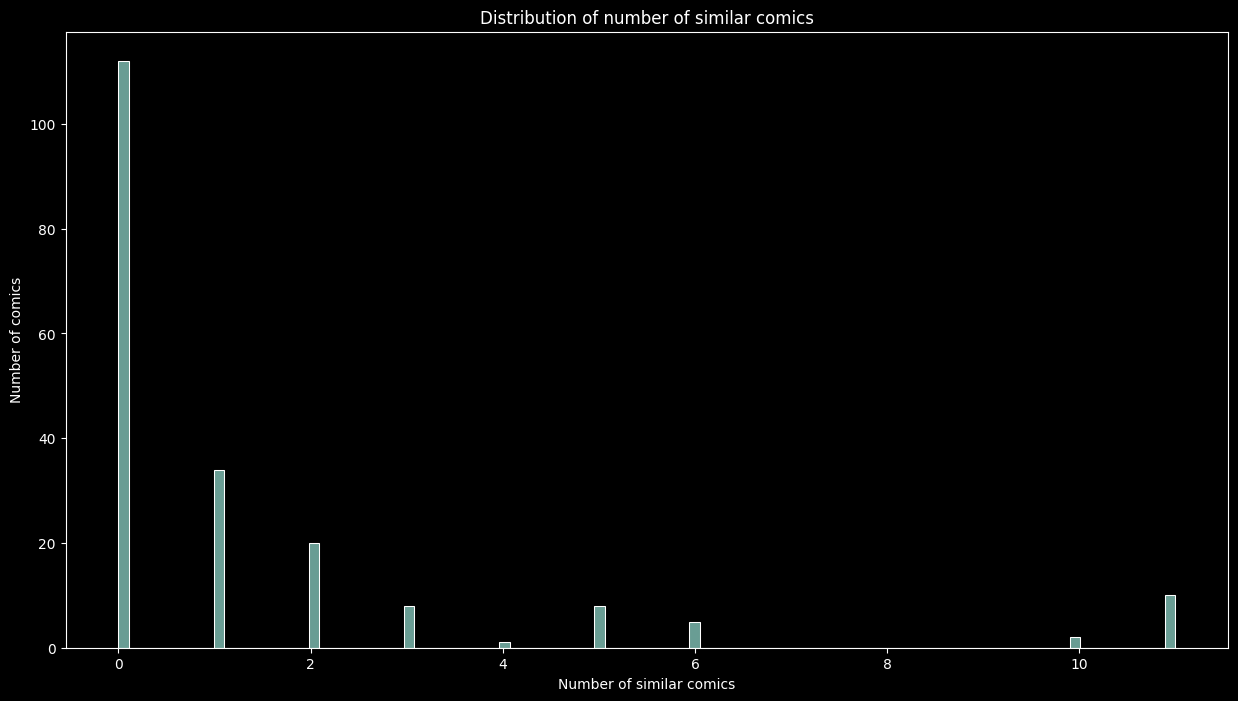

Comics mit den meisten ähnlichen Comics:
['M/SHSW 1', 'M/SHSW 10', 'M/SHSW 11', 'M/SHSW 12', 'M/SHSW 2', 'M/SHSW 5', 'M/SHSW 6', 'M/SHSW 7', 'M/SHSW 8', 'M/SHSW 9']


In [334]:
# sort the dictionary by the length of the list of similar comics
sorted_non_nan_columns_per_row = {k: v for k, v in sorted(non_nan_columns_per_row.items(), key=lambda item: len(item[1]), reverse=True)}

# plot the lengths of the lists
plt.figure(figsize=(15, 8))
sns.histplot(data=[len(v) for k, v in sorted_non_nan_columns_per_row.items()], bins=100)
plt.title('Distribution of number of similar comics')
plt.xlabel('Number of similar comics')
plt.ylabel('Number of comics')
plt.show()

print("Comics mit den meisten ähnlichen Comics:")
print(list(sorted_non_nan_columns_per_row.keys())[:10])

Die meisten Comics haben bis zu 20 ähnliche Comics / Fortsetzungen. Es gibt jedoch einige Ausreisser, die bis zu etwa 530 ähnliche Comics haben. Diese Comics gehören zu den am stärksten vernetzten Comics im Netzwerk. Die "Fantastic Four" Comics kommen bei diesen Ausreisser oft vor. Dies macht Sinn, da in diesen Comics viele gleiche Helden vorkommen.

## Frage 8 Welche Helden könnten in einem Comic zusammen auftreten?

Um diese Frage zu beantworten, werden wir [Link Prediction](https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html) und [Common Neighbors](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.common_neighbors.html) verwenden.

In [335]:
import itertools

def predict_links(G, top_n=10):
    """
    Predict future links using the number of common neighbors.
    
    Parameters:
    G (nx.Graph): The graph on which to perform link prediction.
    top_n (int): The number of link predictions to return.
    
    Returns:
    list of tuples: A list of the top predicted links and their scores.
    """
    # Calculate all possible non-existent edges
    potential_links = [(node1, node2) for node1, node2 in itertools.combinations(G.nodes(), 2) if not G.has_edge(node1, node2)]
    
    # Get the number of common neighbors between each pair of nodes
    scores = [(node1, node2, len(list(nx.common_neighbors(G, node1, node2)))) for node1, node2 in potential_links]
    
    # Sort the potential links
    scores.sort(key=lambda x: x[2], reverse=True)
    
    return scores[:top_n]

predicted_links = predict_links(G_one_mode, top_n=10)
for link in predicted_links:
    print(f"{link[0]} - {link[1]}: {link[2]} gemeinsame Nachbarn")

KeyboardInterrupt: 

Aufgelistet sind Paare von Marvel-Helden, welche keine direkte Verbindung zu einander haben. Die Helden sind nach der Anzahl gemeinsame Nachbarn sortiert. Je mehr, desto wahrscheinlicher ist es, dass sie in einem Comic zusammen auftreten könnten.

Dies ist eventuell für die Marvel-Publisher interessant, da sie so neue Ideen für Comics erhalten könnten. Neue Verbindungen könnten hergestellt werden, welche vorher noch nicht existierten und so könnten etwas unbekanntere Helden promoted werden.

## Ausblick

Für die Zukunft dieses Projekts zur Analyse des Marvel-Sozialnetzwerks gibt es mehrere spannende Erweiterungsmöglichkeiten, die zu einem tieferen Verständnis des Universums und seiner Charakterdynamik führen könnten:

### Erweiterung der Datengrundlage

Die Integration von Informationen aus verschiedenen Medienformaten wie Filmen, TV-Serien und Videospielen kann zu einem gesamtheitlichen Bild des Marvel-Universums beitragen. Dazu gehören nicht nur die Beziehungen zwischen den Helden, sondern auch die zu ihren Gegenspielern. Ein umfassendes Bild der Feindschaften, Allianzen und Konflikte könnte aufzeigen, wie Charakterbeziehungen das narrative Gefüge prägen.

### Tiefere Einblicke in Charakterinteraktionen

Durch die Analyse der Feinde der Helden und der Konflikte zwischen ihnen könnte man verstehen, welche Charaktere die Hauptantagonisten innerhalb des Universums sind. Es wäre interessant zu erforschen, ob und wie die Präsenz von Feinden die Verbindungen zwischen Helden beeinflusst, sowie die Dynamik von Helden, die sich gegenseitig bekämpfen.

#### Historische Analyse (Jahreszahlen)

Eine zeitliche Analyse der Charakterentwicklungen und ihrer Interaktionen könnte Trends und Muster in der Erzählentwicklung offenlegen. Dabei könnten wichtige Ereignisse wie der Tod eines Helden oder signifikante Wendepunkte in der Storyline Berücksichtigung finden.

### Einsatz von Web-Crawlern und APIs

Ein systematischer Einsatz von Web-Crawlern, insbesondere die Nutzung der [Marvel API](https://developer.marvel.com/), kann dabei helfen, die Datenbanken kontinuierlich zu aktualisieren und zu erweitern. Automatisierte Skripte könnten neue Veröffentlichungen und Informationen in Echtzeit erfassen, was die Analyse aktuell und relevant hält.

### Optimierung der Berechnungsmethoden

Effiziente Algorithmen und Rechentechniken sind nötig, um mit der wachsenden Datenmenge umzugehen. Hier könnten beispielsweise maschinelles Lernen und Netzwerk-Sampling-Techniken zum Einsatz kommen, um die Berechnung von Metriken und Vorhersagen zu beschleunigen.